In [1860]:
# import the dependencies
import sys
sys.path.insert(1, '../../')
sys.path.insert(1, '../')


# general imports
import warnings
import numpy as np
import pandas as pd
import scanpy as sc
from anndata import AnnData as ad
import decoupler as dc
from tabulate import tabulate


import tensorflow as tf
from tensorflow.keras.utils import to_categorical

from scipy.stats import spearmanr, pearsonr
from collections import Counter

# Images, plots, display, and visualization
import matplotlib.pyplot as plt
from matplotlib_venn import venn3_unweighted
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale


from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
# programming stuff
import time
import os, sys
import pickle
from pathlib import Path


In [1861]:
def make_prop_table(adata, obs):
    num_cell_counter = Counter(adata.obs[obs])
    num_cells = list()
    cell_types = list()
    prop_cells = list()
    tot_count = 0
    tot_prop = 0

    for cell in num_cell_counter:
        num_cells.append(num_cell_counter[cell])
        cell_types.append(cell)
        tot_count = tot_count + num_cell_counter[cell]

    for cell in num_cell_counter:
        proportion = num_cell_counter[cell] / tot_count
        prop_cells.append(proportion)
        tot_prop = tot_prop + proportion

    cell_types.append('Total')
    num_cells.append(tot_count)
    prop_cells.append(tot_prop)
    table = {'Cell_Types': cell_types, 
        'Num_Cells': num_cells, 
        'Prop_Cells': prop_cells}
    table = pd.DataFrame(table)
    print(tabulate(table,  headers='keys', tablefmt='fancy_grid', showindex = True))
    return table    

In [1862]:
#scanpy config.
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.22.4 scipy==1.7.3 pandas==1.5.2 scikit-learn==1.1.3 statsmodels==0.13.5 python-igraph==0.10.2 louvain==0.8.0 pynndescent==0.5.4


Importing both datasets SN, SC and Bulk from same mouse:

In [1863]:
#reading in the combined data (normalized separately) processed in R Seurat
path = os.getcwd()
sn_path = f"{path}/../data/mouse_kidney/GSE141115_withnames/M7_SN_FANS_3×500g.txt.gz"
sn_adata = sc.read_text(sn_path)
sn_adata

AnnData object with n_obs × n_vars = 16524 × 8611

In [1864]:
sc_path = f"{path}/../data/mouse_kidney/GSE141115_withnames/M7_SC_ColdDiss_Fresh.txt.gz"
sc_adata = sc.read_text(sc_path)
sc_adata

AnnData object with n_obs × n_vars = 14310 × 4606

In [1865]:
bulk_path = f"{path}/../data/mouse_kidney/GSE141115_withnames/M7_BulkSeq_ColdDiss_Fresh.txt.gz"
bulk_adata = sc.read_text(bulk_path, delimiter=None)
bulk_adata

AnnData object with n_obs × n_vars = 29071 × 1

In [1866]:
#they need transposing, genes and obs are switched:
sn_adata.obs

""
Sox17
Mrpl15
Lypla1
Tcea1
Atp6v1h
...
Gm16090
Mc2r
Chrm1
Olfr1443


In [1867]:
#both datasets need transposing:
sn_adata = sn_adata.transpose()
sc_adata = sc_adata.transpose()
bulk_adata = bulk_adata.transpose()

In [1868]:
sn_adata.obs

""
MJ06_SN_AAACCTGAGATCCCGC
MJ06_SN_AAACCTGAGCCACTAT
MJ06_SN_AAACCTGAGCGTGAAC
MJ06_SN_AAACCTGAGTACGCGA
MJ06_SN_AAACCTGCAACACCTA
...
MJ06_SN_TTTGTCAGTGCAACGA
MJ06_SN_TTTGTCAGTTCCATGA
MJ06_SN_TTTGTCATCCTACAGA
MJ06_SN_TTTGTCATCGCGATCG


In [1869]:
sn_adata.var_names_make_unique()
sc_adata.var_names_make_unique()  

Assigning cell types to each:

In [1870]:
#importing the paper's excel sheet with cell types:
cell_path = f"{path}/../data/mouse_kidney/cell_assignments/13059_2020_2048_MOESM3_ESM.xlsx"
cell_assign_sn = pd.read_excel(cell_path, sheet_name = 'cells_and_nuclei_v2_chemistry')
cell_assign_sn

,Unnamed: 0,Library,Protocol,Cell type
0,MJ03_BG70_AAACCTGAGCTGCAAG,MJ03,SC_v2,PT
1,MJ03_BG70_AAACCTGAGCTGCGAA,MJ03,SC_v2,PT
2,MJ03_BG70_AAACCTGCAAGTACCT,MJ03,SC_v2,PT
3,MJ03_BG70_AAACGGGAGATCCGAG,MJ03,SC_v2,PT
4,MJ03_BG70_AAACGGGAGATGAGAG,MJ03,SC_v2,PT
...,...,...,...,...
32997,MJ08_SN_TTTGTCACATCGGGTC,MJ08,SN_FANS_3x500g_v2,aLOH
32998,MJ08_SN_TTTGTCAGTAGCAAAT,MJ08,SN_FANS_3x500g_v2,PT
32999,MJ08_SN_TTTGTCAGTCCAGTGC,MJ08,SN_FANS_3x500g_v2,PT
33000,MJ08_SN_TTTGTCAGTTACTGAC,MJ08,SN_FANS_3x500g_v2,PT


In [1871]:
cell_assign_sc = pd.read_excel(cell_path, sheet_name = 'cells_and_nuclei_v3_chemistry')
cell_assign_sc

,Unnamed: 0,Library,Protocol,Cell type
0,LD01_SC_FRESH_AAACCCACAACCACAT,LD01,SC_v3,CD_IC
1,LD01_SC_FRESH_AAACCCAGTATGACAA,LD01,SC_v3,CD_IC
2,LD01_SC_FRESH_AAACCCAGTTCAAGGG,LD01,SC_v3,CNT
3,LD01_SC_FRESH_AAACCCATCAGCTTCC,LD01,SC_v3,PT
4,LD01_SC_FRESH_AAACCCATCCTTTGAT,LD01,SC_v3,CD_PC
...,...,...,...,...
95670,MJ59_SN_O_TTTGTTGCACCCTCTA,MJ59,SN_sucrose_v3,aLOH
95671,MJ59_SN_O_TTTGTTGCAGCATTGT,MJ59,SN_sucrose_v3,MC
95672,MJ59_SN_O_TTTGTTGGTAGCTGCC,MJ59,SN_sucrose_v3,PT
95673,MJ59_SN_O_TTTGTTGGTGTTAACC,MJ59,SN_sucrose_v3,PT


In [1872]:
sn_celltypes = cell_assign_sn[cell_assign_sn['Library']=='MJ06']
sn_celltypes

,Unnamed: 0,Library,Protocol,Cell type
9153,MJ06_SN_AAACCTGAGATCCCGC,MJ06,SN_FANS_3x500g_v2,aLOH
9154,MJ06_SN_AAACCTGAGCCACTAT,MJ06,SN_FANS_3x500g_v2,aLOH
9155,MJ06_SN_AAACCTGAGCGTGAAC,MJ06,SN_FANS_3x500g_v2,aLOH
9156,MJ06_SN_AAACCTGAGTACGCGA,MJ06,SN_FANS_3x500g_v2,PT
9157,MJ06_SN_AAACCTGCAACACCTA,MJ06,SN_FANS_3x500g_v2,aLOH
...,...,...,...,...
17759,MJ06_SN_TTTGTCAGTGCAACGA,MJ06,SN_FANS_3x500g_v2,PT
17760,MJ06_SN_TTTGTCAGTTCCATGA,MJ06,SN_FANS_3x500g_v2,aLOH
17761,MJ06_SN_TTTGTCATCCTACAGA,MJ06,SN_FANS_3x500g_v2,PT
17762,MJ06_SN_TTTGTCATCGCGATCG,MJ06,SN_FANS_3x500g_v2,PT


In [1873]:
sn_celltypes['Cell type']

9153     aLOH
9154     aLOH
9155     aLOH
9156       PT
9157     aLOH
         ... 
17759      PT
17760    aLOH
17761      PT
17762      PT
17763    aLOH
Name: Cell type, Length: 8611, dtype: object

In [1874]:
sn_adata.obs['cell_type'] = sn_celltypes['Cell type'].values
sn_adata.obs

,cell_type
MJ06_SN_AAACCTGAGATCCCGC,aLOH
MJ06_SN_AAACCTGAGCCACTAT,aLOH
MJ06_SN_AAACCTGAGCGTGAAC,aLOH
MJ06_SN_AAACCTGAGTACGCGA,PT
MJ06_SN_AAACCTGCAACACCTA,aLOH
...,...
MJ06_SN_TTTGTCAGTGCAACGA,PT
MJ06_SN_TTTGTCAGTTCCATGA,aLOH
MJ06_SN_TTTGTCATCCTACAGA,PT
MJ06_SN_TTTGTCATCGCGATCG,PT


In [1875]:
#now assigning sc cell types
sc_celltypes = cell_assign_sc[cell_assign_sc['Library']=='LD01']
sc_celltypes

,Unnamed: 0,Library,Protocol,Cell type
0,LD01_SC_FRESH_AAACCCACAACCACAT,LD01,SC_v3,CD_IC
1,LD01_SC_FRESH_AAACCCAGTATGACAA,LD01,SC_v3,CD_IC
2,LD01_SC_FRESH_AAACCCAGTTCAAGGG,LD01,SC_v3,CNT
3,LD01_SC_FRESH_AAACCCATCAGCTTCC,LD01,SC_v3,PT
4,LD01_SC_FRESH_AAACCCATCCTTTGAT,LD01,SC_v3,CD_PC
...,...,...,...,...
4601,LD01_SC_FRESH_TTTGTTGGTGAGATCG,LD01,SC_v3,PT
4602,LD01_SC_FRESH_TTTGTTGGTTTCACAG,LD01,SC_v3,CNT
4603,LD01_SC_FRESH_TTTGTTGTCCCTCGTA,LD01,SC_v3,aLOH
4604,LD01_SC_FRESH_TTTGTTGTCGAGAGAC,LD01,SC_v3,Endo


In [1876]:
sc_adata.obs['cell_type'] = sc_celltypes['Cell type'].values
sc_adata.obs

,cell_type
LD01_SC_FRESH_AAACCCACAACCACAT,CD_IC
LD01_SC_FRESH_AAACCCAGTATGACAA,CD_IC
LD01_SC_FRESH_AAACCCAGTTCAAGGG,CNT
LD01_SC_FRESH_AAACCCATCAGCTTCC,PT
LD01_SC_FRESH_AAACCCATCCTTTGAT,CD_PC
...,...
LD01_SC_FRESH_TTTGTTGGTGAGATCG,PT
LD01_SC_FRESH_TTTGTTGGTTTCACAG,CNT
LD01_SC_FRESH_TTTGTTGTCCCTCGTA,aLOH
LD01_SC_FRESH_TTTGTTGTCGAGAGAC,Endo


In [1877]:
sn_genes = pd.DataFrame(sn_adata.var) 
sc_genes = pd.DataFrame(sc_adata.var)
bulk_genes = pd.DataFrame(bulk_adata.var)

In [1878]:
sn_genes

""
Sox17
Mrpl15
Lypla1
Tcea1
Atp6v1h
...
Gm16090
Mc2r
Chrm1
Olfr1443


In [1879]:
sc_genes

""
Sox17
Mrpl15
Lypla1
Tcea1
Atp6v1h
...
Rmi2
Smoc2
Treml2
Gm37387


In [1880]:
bulk_genes

""
Xkr4
RP23-317L18.4
RP23-317L18.3
RP23-115I1.2
RP23-122M2.3
...
AC168977.1
PISD
DHRSX
CAAA01098150.1


In [1881]:
sn_genes = sn_genes.transpose()
sc_genes = sc_genes.transpose()
bulk_genes = bulk_genes.transpose()

In [1882]:
common_genes = np.intersect1d(sc_genes.columns, sn_genes.columns)
common_genes= list(common_genes)
common_genes

['0610007P14Rik',
 '0610009B22Rik',
 '0610009L18Rik',
 '0610009O20Rik',
 '0610010F05Rik',
 '0610010K14Rik',
 '0610011F06Rik',
 '0610012G03Rik',
 '0610025J13Rik',
 '0610030E20Rik',
 '0610033M10Rik',
 '0610037L13Rik',
 '0610038B21Rik',
 '0610040B10Rik',
 '0610040F04Rik',
 '0610040J01Rik',
 '0610043K17Rik',
 '1010001B22Rik',
 '1110001J03Rik',
 '1110002L01Rik',
 '1110004E09Rik',
 '1110004F10Rik',
 '1110006O24Rik',
 '1110008F13Rik',
 '1110008L16Rik',
 '1110008P14Rik',
 '1110012L19Rik',
 '1110019D14Rik',
 '1110020A21Rik',
 '1110032A03Rik',
 '1110034G24Rik',
 '1110035H17Rik',
 '1110037F02Rik',
 '1110038F14Rik',
 '1110046J04Rik',
 '1110051M20Rik',
 '1110059E24Rik',
 '1110059G10Rik',
 '1110065P20Rik',
 '1190002N15Rik',
 '1190005I06Rik',
 '1190007I07Rik',
 '1300002E11Rik',
 '1500002C15Rik',
 '1500011B03Rik',
 '1500011K16Rik',
 '1500015A07Rik',
 '1500015O10Rik',
 '1500026H17Rik',
 '1600002H07Rik',
 '1600002K03Rik',
 '1600010M07Rik',
 '1600012H06Rik',
 '1600014C10Rik',
 '1600020E01Rik',
 '1700001L

In [1883]:
common_genes_wbulk = np.intersect1d(common_genes, bulk_genes.columns)
common_genes_wbulk = list(common_genes_wbulk)
common_genes_wbulk

['0610007P14Rik',
 '0610009B22Rik',
 '0610009L18Rik',
 '0610009O20Rik',
 '0610010F05Rik',
 '0610010K14Rik',
 '0610011F06Rik',
 '0610012G03Rik',
 '0610025J13Rik',
 '0610030E20Rik',
 '0610033M10Rik',
 '0610037L13Rik',
 '0610038B21Rik',
 '0610040B10Rik',
 '0610040F04Rik',
 '0610040J01Rik',
 '0610043K17Rik',
 '1010001B22Rik',
 '1110001J03Rik',
 '1110002L01Rik',
 '1110004E09Rik',
 '1110004F10Rik',
 '1110006O24Rik',
 '1110008F13Rik',
 '1110008L16Rik',
 '1110008P14Rik',
 '1110012L19Rik',
 '1110019D14Rik',
 '1110020A21Rik',
 '1110032A03Rik',
 '1110034G24Rik',
 '1110035H17Rik',
 '1110037F02Rik',
 '1110038F14Rik',
 '1110046J04Rik',
 '1110051M20Rik',
 '1110059E24Rik',
 '1110059G10Rik',
 '1110065P20Rik',
 '1190002N15Rik',
 '1190005I06Rik',
 '1190007I07Rik',
 '1300002E11Rik',
 '1500002C15Rik',
 '1500011B03Rik',
 '1500011K16Rik',
 '1500015A07Rik',
 '1500015O10Rik',
 '1500026H17Rik',
 '1600002H07Rik',
 '1600002K03Rik',
 '1600010M07Rik',
 '1600012H06Rik',
 '1600014C10Rik',
 '1600020E01Rik',
 '1700001L

In [1884]:
#common genes between SN and Bulk
common_genes_snwbulk = np.intersect1d(sn_genes.columns, bulk_genes.columns)
common_genes_snwbulk = list(common_genes_snwbulk)
#common genes between SC and Bulk
common_genes_scwbulk = np.intersect1d(sc_genes.columns, bulk_genes.columns)
common_genes_scwbulk = list(common_genes_scwbulk)

In [1885]:
#common genes between bulk, SN, and SC.
len(common_genes_wbulk)

13686

In [1886]:
#common genes between SN and SC only, no bulk.
len(common_genes)

13707

In [1887]:
#calculating variables to plot on Venn and see gene discrepancies.
val5 =  len(np.setxor1d(common_genes_wbulk, common_genes_snwbulk))
val6 =  len(np.setxor1d(common_genes_wbulk, common_genes_scwbulk))
val3 = len(common_genes) - len(common_genes_wbulk)
val7 = len(common_genes_wbulk)
val4= bulk_genes.shape[1] - val7 - val5 - val6
val7 = len(common_genes_wbulk)
val1 = sn_genes.shape[1] - val3 - val7 - val5
val2 = sc_genes.shape[1] -  val3 - val7 - val6

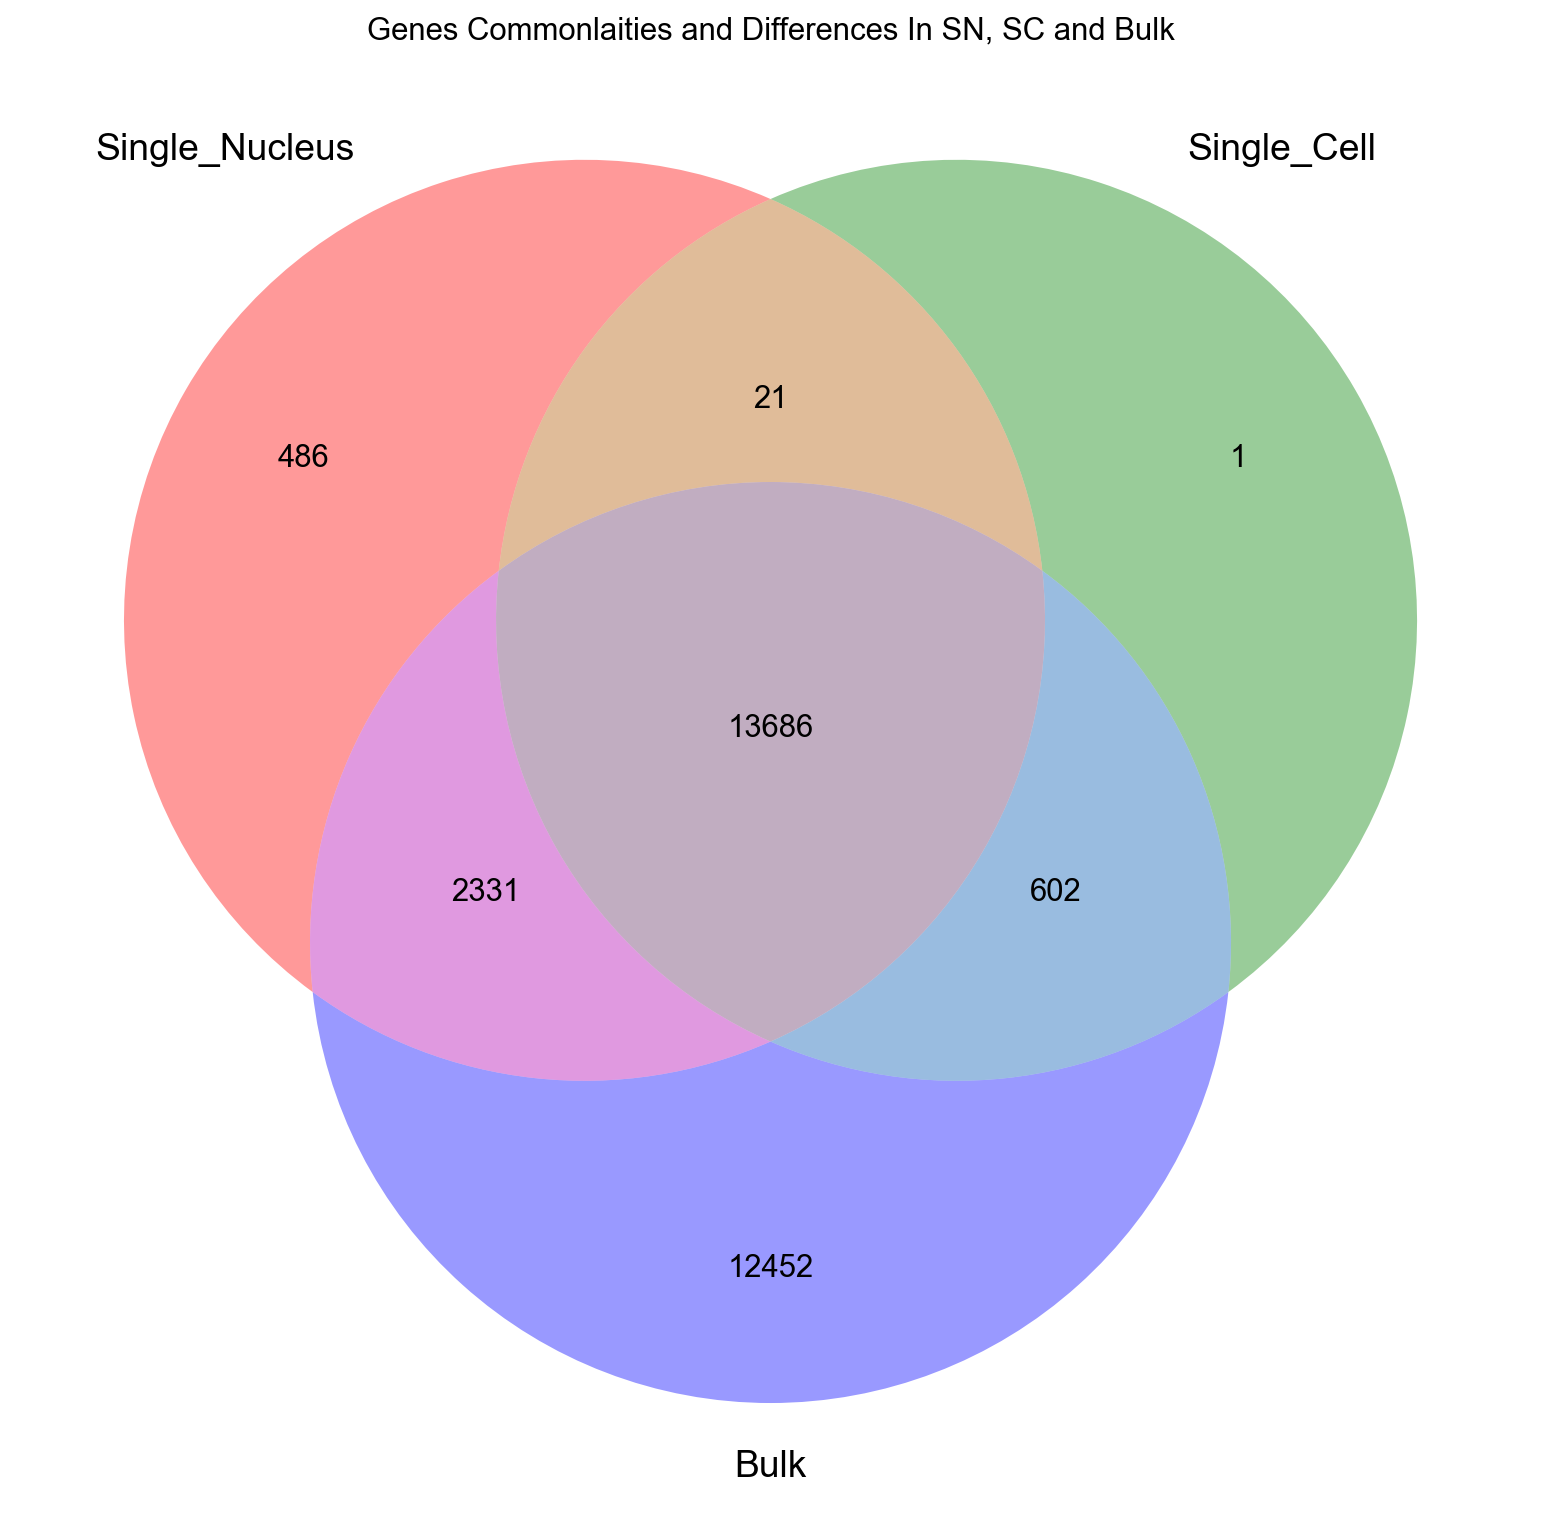

In [1888]:
#venn diagram for gene discrepancies
plt.figure(figsize=(15,12))  
gene_venn = venn3_unweighted(subsets =(val1, 
                            val2,
                            val3,
                            val4,
                            val5,
                            val6,
                            val7), 
                              set_labels = ('Single_Nucleus', 'Single_Cell', 'Bulk')
                            )
plt.title("Genes Commonlaities and Differences In SN, SC and Bulk")                  
plt.show()

In [1889]:
#Code based from https://github.com/scverse/anndata/issues/73 falexwolf commented on Oct 20, 2018
#trimming down the sc_adata to contain only the genes available in common_genes SN and SC
common_gene_indicator = np.in1d(sc_adata.var_names, common_genes)
sc_adata = sc_adata[:, common_gene_indicator]
sc_adata

View of AnnData object with n_obs × n_vars = 4606 × 13707
    obs: 'cell_type'

In [1890]:
#Code based from https://github.com/scverse/anndata/issues/73 falexwolf commented on Oct 20, 2018
#trimming down the sn_adta to contain only genes available in common_genes SN and SC
common_gene_indicator = np.in1d(sn_adata.var_names, common_genes)
sn_adata = sn_adata[:, common_gene_indicator]
sn_adata

View of AnnData object with n_obs × n_vars = 8611 × 13707
    obs: 'cell_type'

QCing the single nucleus data first:

/Users/ivicha/miniconda3/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:00)


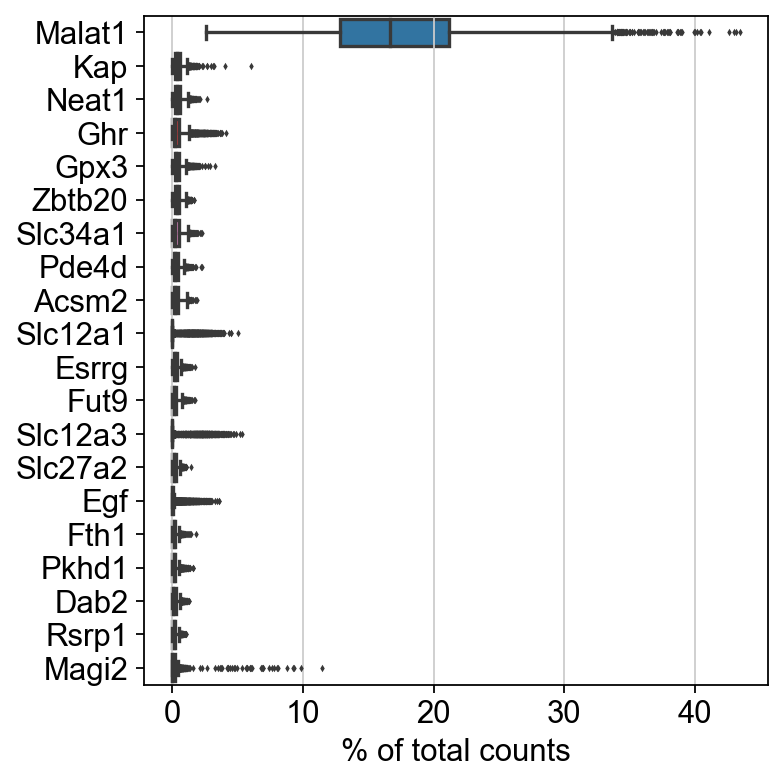

In [1891]:
sc.pl.highest_expr_genes(sn_adata, n_top=20, )

In [1892]:
#sc.pp.filter_cells(sn_adata, min_genes=200)
#sc.pp.filter_genes(sn_adata, min_cells=3)

In [1893]:
sn_adata.var['mt'] = sn_adata.var_names.str.startswith('Mt')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(sn_adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

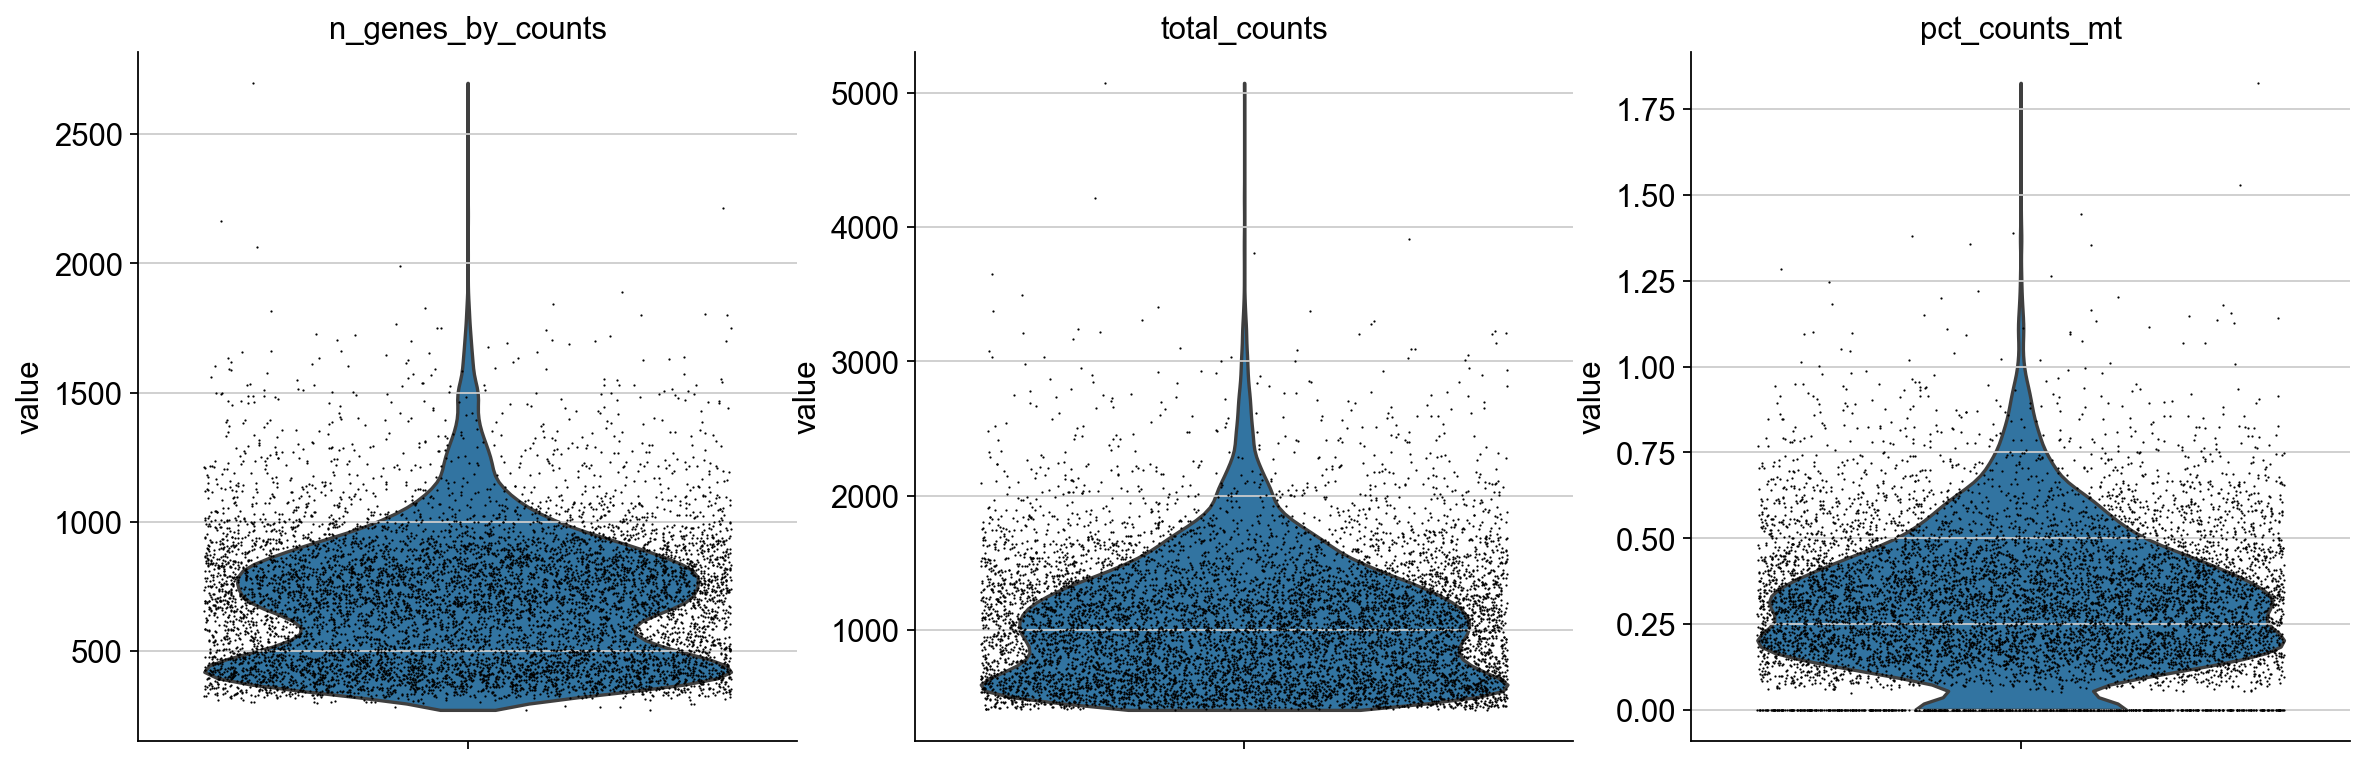

In [1894]:
sc.pl.violin(sn_adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

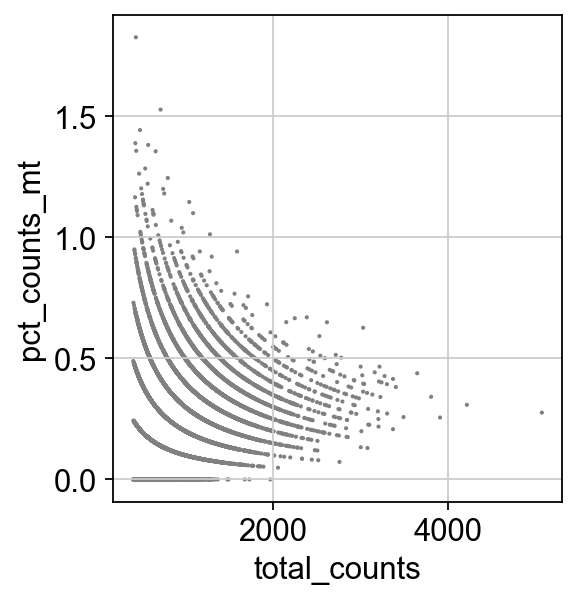

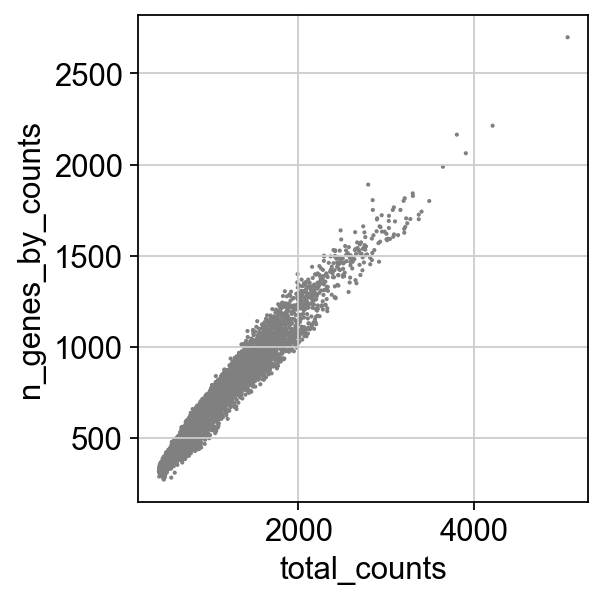

In [1895]:
sc.pl.scatter(sn_adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(sn_adata, x='total_counts', y='n_genes_by_counts')

In [1896]:
#sn_data = sn_adata[sn_adata.obs.n_genes_by_counts < 2000, :]
#sn_adata = sn_adata[sn_adata.obs.pct_counts_mt < 1.5, :]

In [1897]:
sn_adata

AnnData object with n_obs × n_vars = 8611 × 13707
    obs: 'cell_type', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [1898]:
#sc.pp.normalize_total(sn_adata, target_sum=1e4)
sc.pp.log1p(sn_adata)

In [1899]:
sc.pp.highly_variable_genes(sn_adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


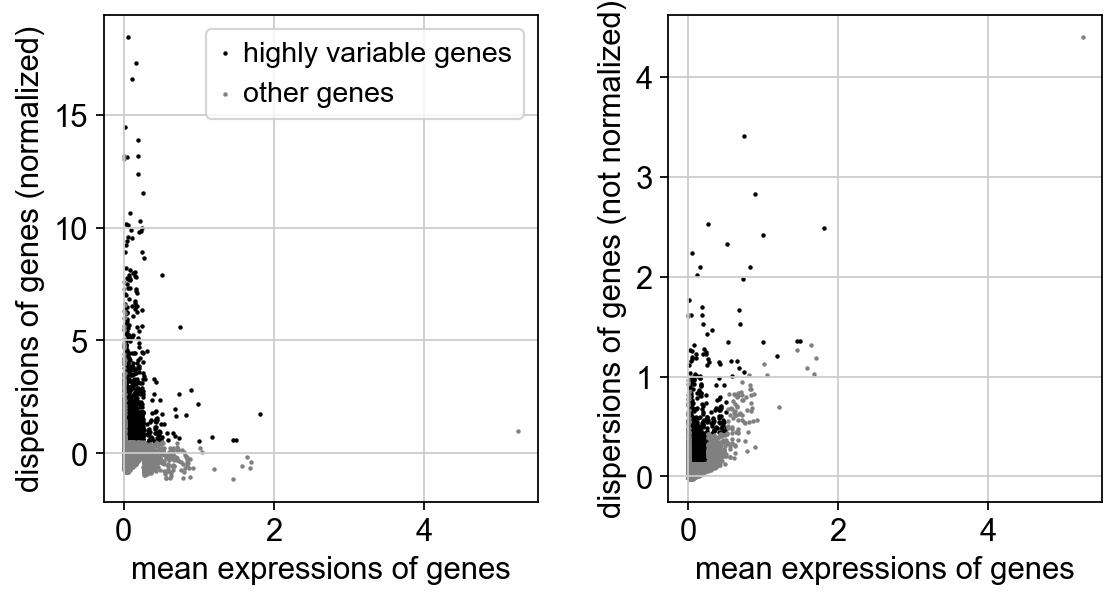

In [1900]:
sc.pl.highly_variable_genes(sn_adata)

In [1901]:
#sn_adata = sn_adata[:, sn_adata.var.highly_variable]

In [1902]:
#sc.pp.regress_out(sn_adata, ['total_counts', 'pct_counts_mt'])

In [1903]:
#sc.pp.scale(sn_adata, max_value=10)

Now QC the single-cell dataset:

normalizing counts per cell


/Users/ivicha/miniconda3/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


    finished (0:00:00)


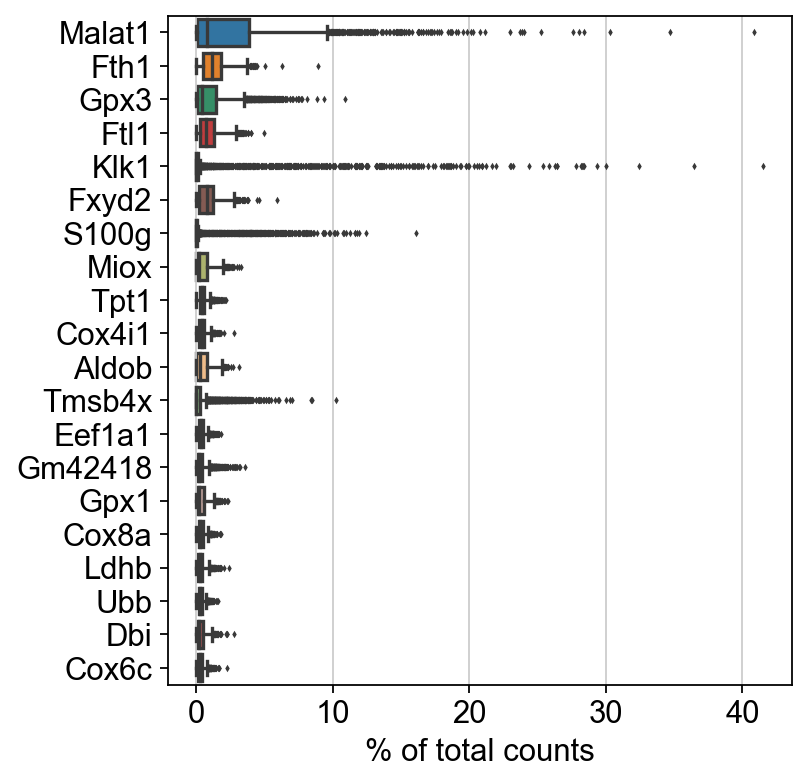

In [1904]:
sc.pl.highest_expr_genes(sc_adata, n_top=20, )

In [1905]:
#sc.pp.filter_cells(sc_adata, min_genes=200)
#sc.pp.filter_genes(sc_adata, min_cells=3)

In [1906]:
sc_adata.var['mt'] = sc_adata.var_names.str.startswith('Mt')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(sc_adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

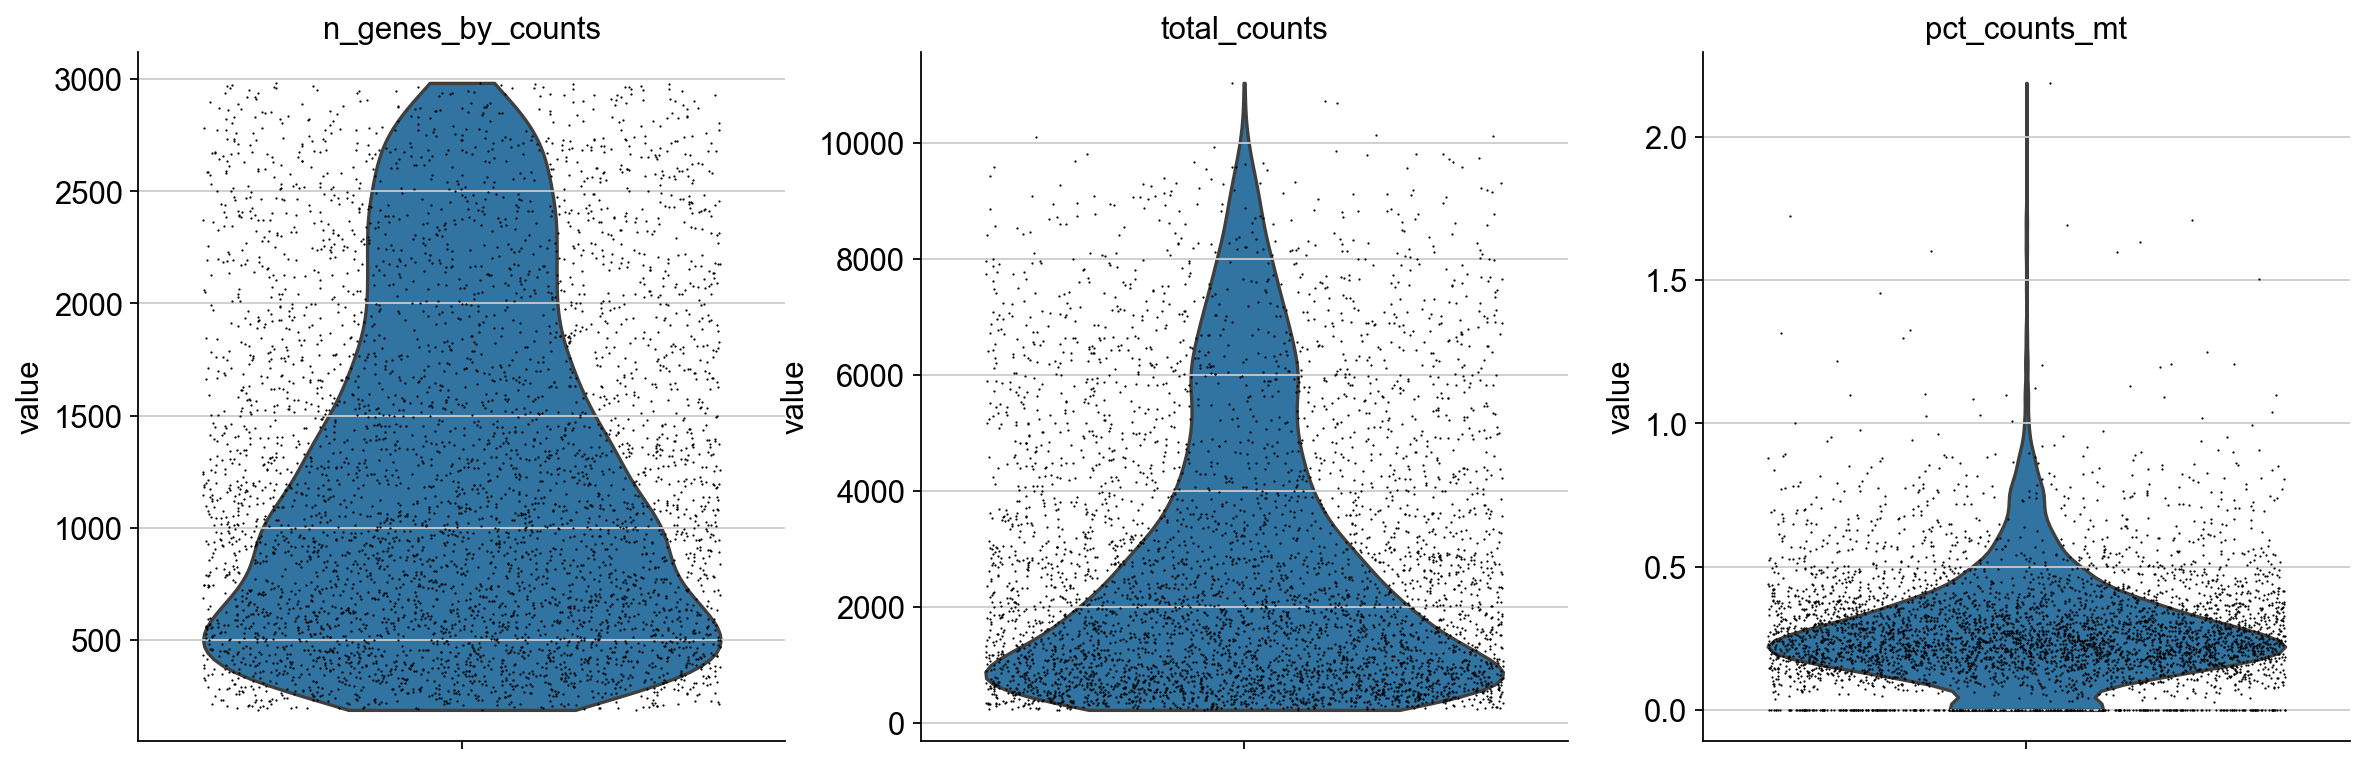

In [1907]:
sc.pl.violin(sc_adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

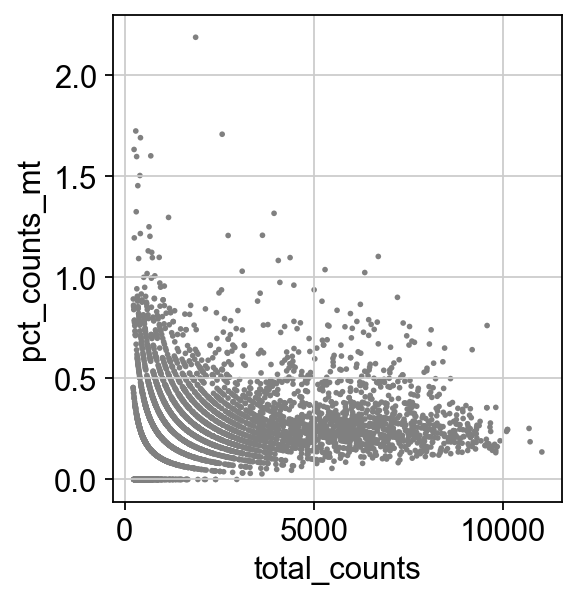

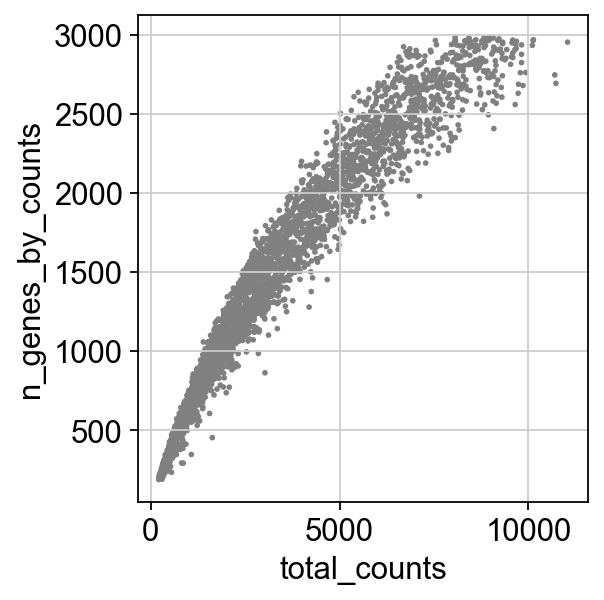

In [1908]:
sc.pl.scatter(sc_adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(sc_adata, x='total_counts', y='n_genes_by_counts')

In [1909]:
#sc_data = sc_adata[sc_adata.obs.n_genes_by_counts < 10000, :]
#sc_adata = sc_adata[sc_adata.obs.pct_counts_mt < 1, :]

In [1910]:
sc_adata.X

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [1911]:
#normalize and logarize:
#sc.pp.normalize_total(sc_adata, target_sum=1e4)
sc.pp.log1p(sc_adata)

In [1912]:
sc.pp.highly_variable_genes(sc_adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


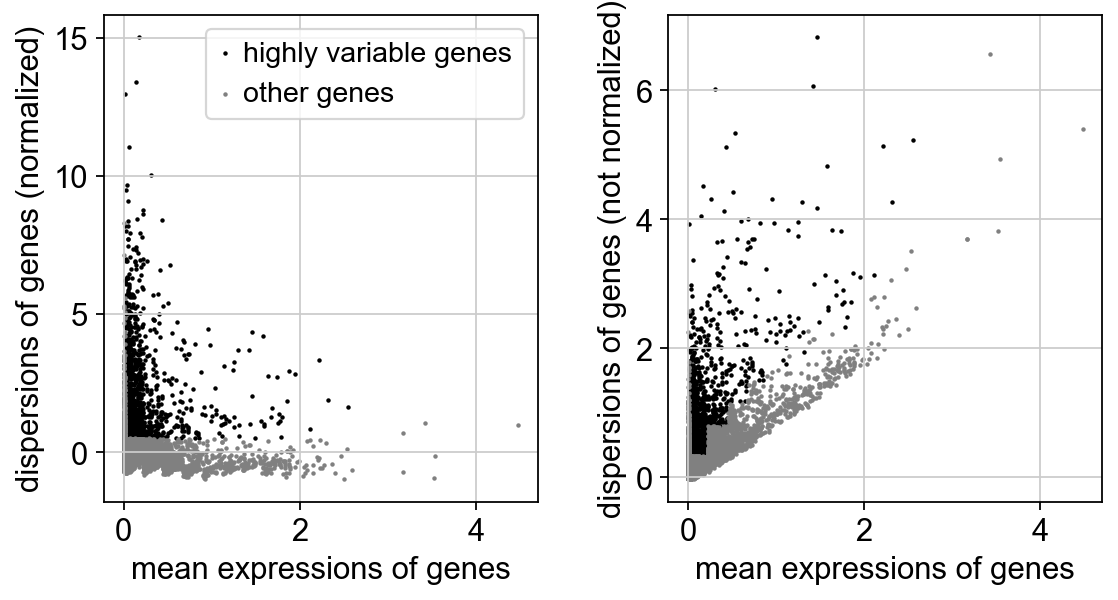

In [1913]:
sc.pl.highly_variable_genes(sc_adata)

In [1914]:
#sc_adata = sc_adata[:, sc_adata.var.highly_variable]

In [1915]:
#sc.pp.regress_out(sc_adata, ['total_counts', 'pct_counts_mt'])

In [1916]:
#sc.pp.scale(sc_adata, max_value=10)

and now QCing the bulk dataset:

normalizing counts per cell
    finished (0:00:00)


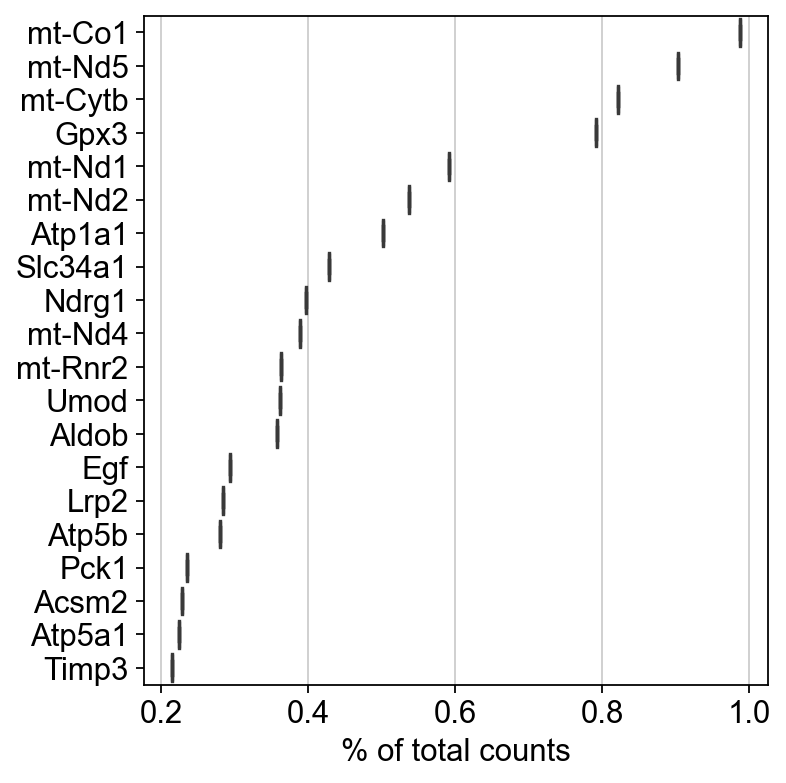

In [1917]:
sc.pl.highest_expr_genes(bulk_adata, n_top=20, )

In [1918]:
bulk_adata.var['mt'] = bulk_adata.var_names.str.startswith('Mt')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(bulk_adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

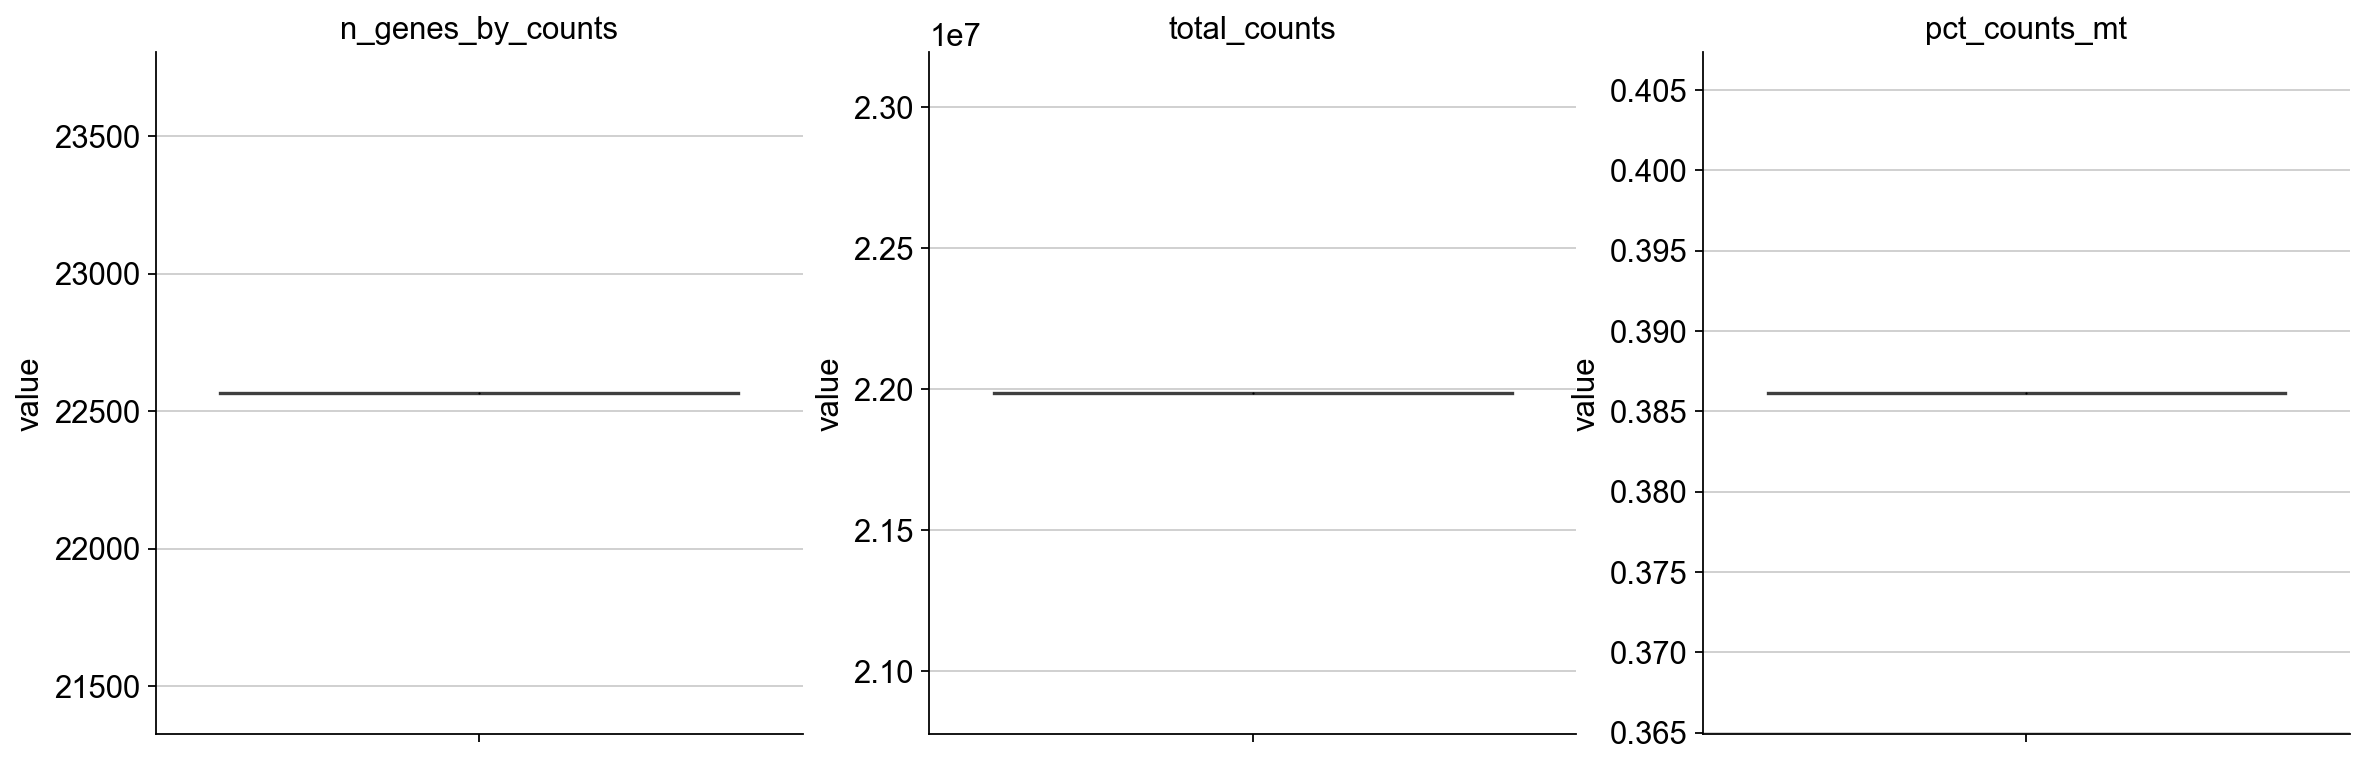

In [1919]:
sc.pl.violin(bulk_adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

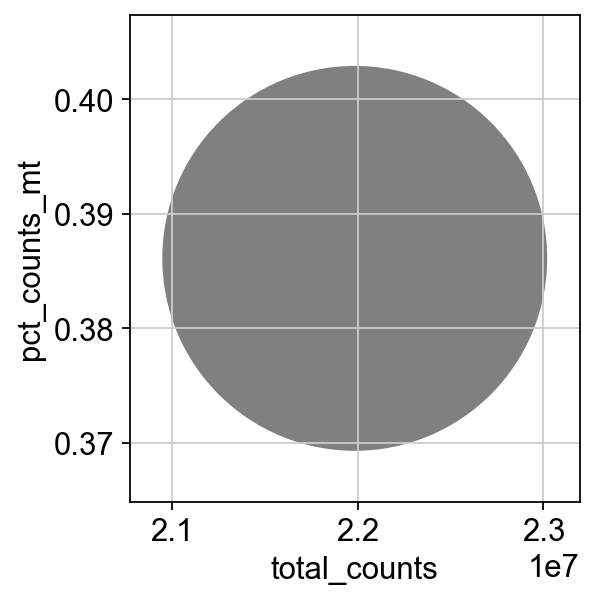

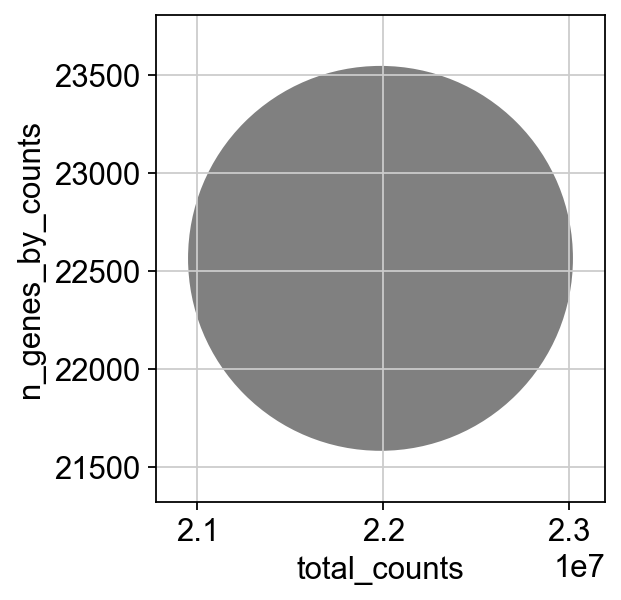

In [1920]:
sc.pl.scatter(bulk_adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(bulk_adata, x='total_counts', y='n_genes_by_counts')

In [1921]:
#normalize and logarize:
#sc.pp.normalize_total(bulk_adata, target_sum=1e4)
sc.pp.log1p(bulk_adata)
#sc.pp.regress_out(bulk_adata, ['total_counts', 'pct_counts_mt'])

In [1922]:
#sc.pp.regress_out(bulk_adata, ['total_counts', 'pct_counts_mt'])

Computing Clustering:

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:09)
running Leiden clustering
    finished: found 23 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 20 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)


/Users/ivicha/miniconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


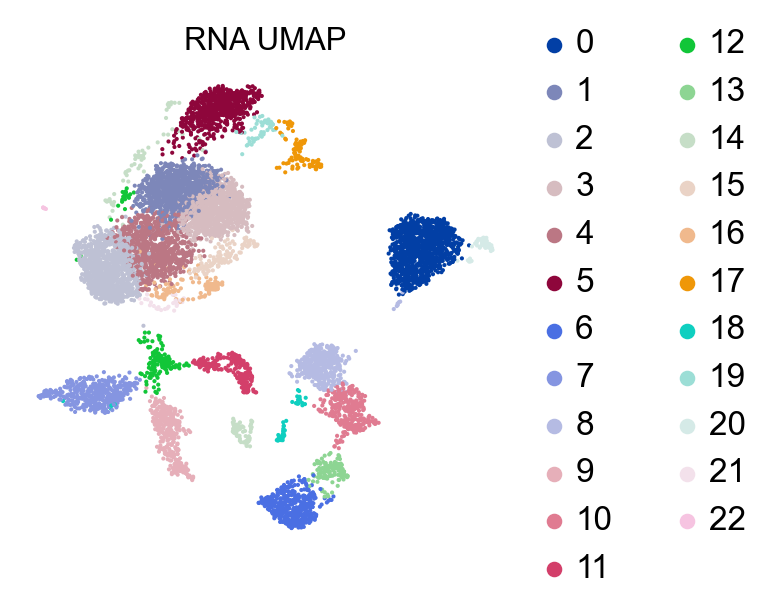

In [1924]:
# Generate PCA features
sc.tl.pca(sn_adata , svd_solver='arpack')

# Compute distances in the PCA space, and find cell neighbors
sc.pp.neighbors(sn_adata , n_neighbors=5, n_pcs=40)

# Generate UMAP features
sc.tl.umap(sn_adata )

# Run leiden clustering algorithm
sc.tl.leiden(sn_adata)
sc.tl.louvain(sn_adata)

# Visualize
sc.pl.umap(sn_adata, color='leiden', title='RNA UMAP',
           frameon=False, legend_fontweight='normal', legend_fontsize=15)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:05)
running Leiden clustering
    finished: found 34 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 33 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)


/Users/ivicha/miniconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


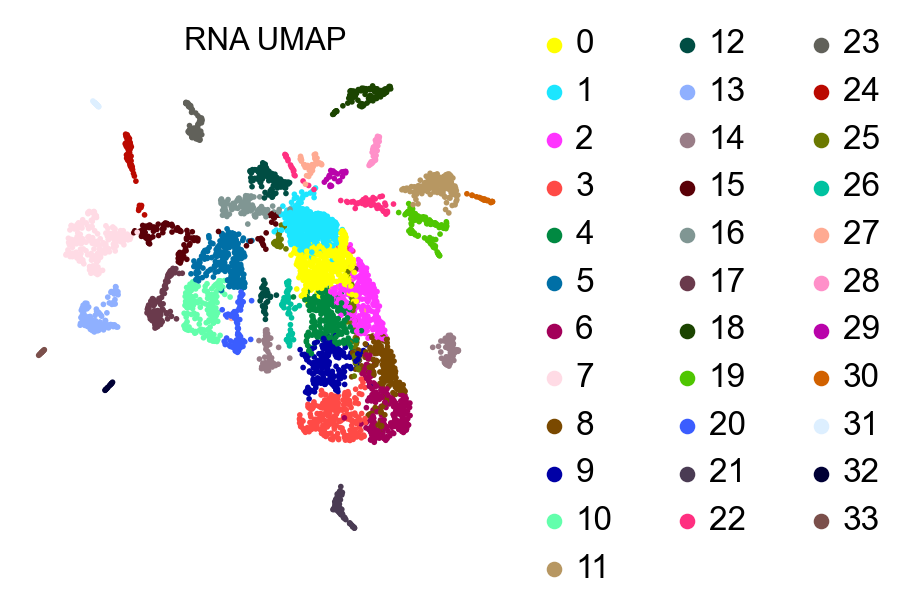

In [1925]:
# Generate PCA features
sc.tl.pca(sc_adata, svd_solver='arpack')

# Compute distances in the PCA space, and find cell neighbors
sc.pp.neighbors(sc_adata, n_neighbors=5, n_pcs=40)

# Generate UMAP features
sc.tl.umap(sc_adata)

# Run leiden and louvain clustering algorithm
sc.tl.leiden(sc_adata)
sc.tl.louvain(sc_adata)

# Visualize
sc.pl.umap(sc_adata, color='leiden', title='RNA UMAP',
           frameon=False, legend_fontweight='normal', legend_fontsize=15)

/Users/ivicha/miniconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


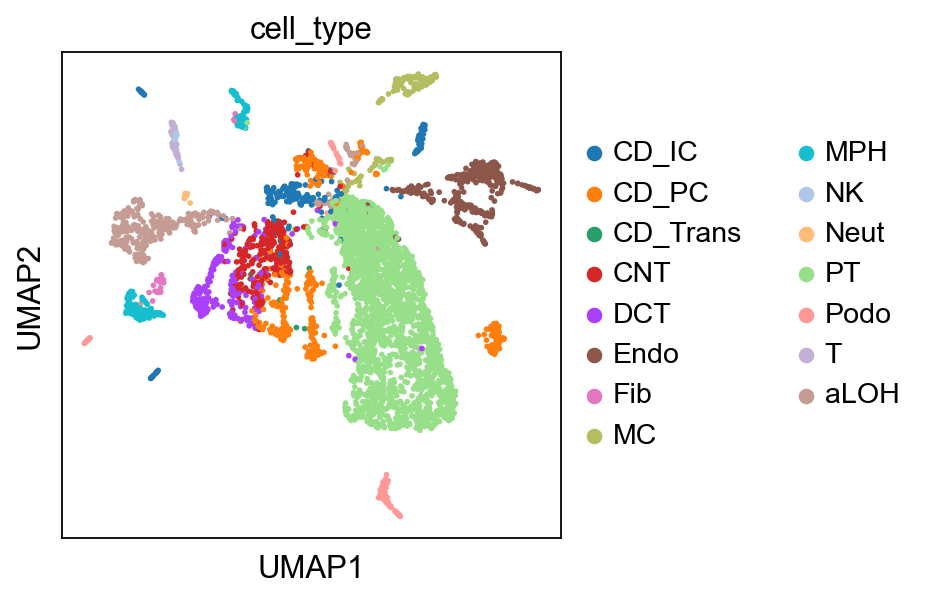

In [1926]:
# Visualize cell assignments:
sc.pl.umap(sc_adata, color='cell_type')

/Users/ivicha/miniconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


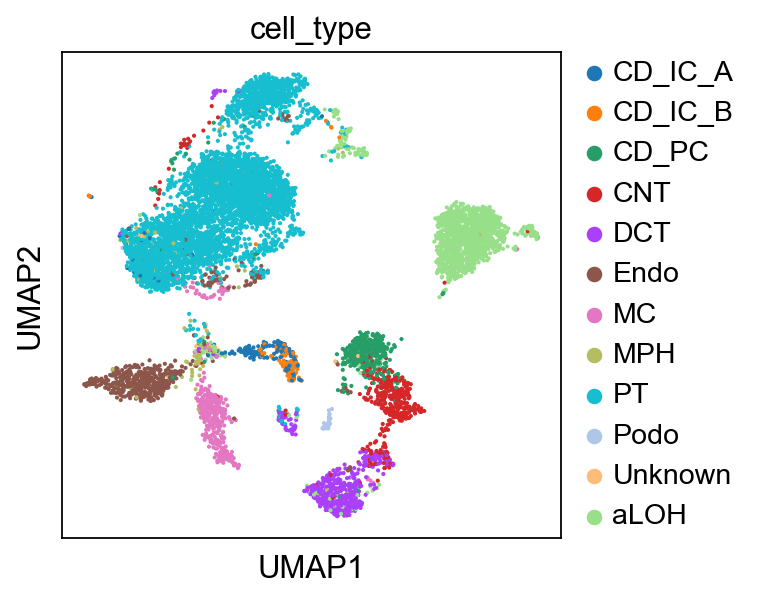

In [1927]:
# Visualize cell assignments:
sc.pl.umap(sn_adata, color='cell_type')

B, B cells; 

CD-IC, collecting duct intercalated cells; 

CD-PC, collecting duct principal cells; 

CNT-CDT, connecting tubule and distal convoluted tubule cells; 

damaged PT, damaged proximal tubular cells; 

DC, dendritic cells; 

Endo, endothelial cells; 

LOH, loop of Henle cells; 

MΦ, macrophages; 

Mes, mesangial cells; 

NK, natural killer cells; 

Neutro, neutrophilic granulocytes; 

Podo, podocytes; 

PT, proximal tubular cells; 

T, T cells.


Matching cell types for comparison:

In [1928]:
Counter(sn_adata.obs['cell_type'])

Counter({'aLOH': 1253,
         'PT': 4671,
         'CD_PC': 433,
         'DCT': 528,
         'MC': 403,
         'CNT': 396,
         'Podo': 46,
         'Endo': 524,
         'CD_IC_A': 179,
         'MPH': 83,
         'CD_IC_B': 84,
         'Unknown': 11})

In [1929]:
new_cell_names_sn = dict(aLOH = 'aLOH',
                     PT = 'PT',
                     CD_PC = 'CD_PC',
                     DCT = 'DCT', 
                     MC = 'MC',
                     CNT = 'CNT', 
                     Podo = 'Podo', 
                     Endo = 'Endo', 
                     CD_IC_A = 'CD_IC', 
                     MPH = 'MPH',
                     CD_IC_B= 'CD_IC',
                     Unknown = 'Unknown')

sn_adata.obs['cell_type'] = (
    sn_adata.obs['cell_type']
    .map(new_cell_names_sn )
    .astype('category')
)


In [1930]:
Counter(sn_adata.obs['cell_type'])

Counter({'aLOH': 1253,
         'PT': 4671,
         'CD_PC': 433,
         'DCT': 528,
         'MC': 403,
         'CNT': 396,
         'Podo': 46,
         'Endo': 524,
         'CD_IC': 263,
         'MPH': 83,
         'Unknown': 11})

In [1931]:
Counter(sc_adata.obs['cell_type'])

Counter({'CD_IC': 220,
         'CNT': 305,
         'PT': 2319,
         'CD_PC': 375,
         'MC': 142,
         'Endo': 334,
         'DCT': 234,
         'Podo': 99,
         'aLOH': 317,
         'MPH': 159,
         'CD_Trans': 5,
         'NK': 11,
         'Fib': 33,
         'T': 46,
         'Neut': 7})

In [1932]:
new_cell_names_sc = dict(
         CD_IC= 'CD_IC',
         CNT = 'CNT',
         PT= 'PT',
         CD_PC = 'CD_PC',
         MC = 'MC',
         Endo = 'Endo',
         DCT= 'DCT',
         Podo = 'Podo',
         aLOH = 'aLOH',
         MPH = 'MPH',
         CD_Trans= 'CD_Trans',
         NK = 'NK',
         Fib = 'Fib',
         T = 'T',
         Neut = 'Neut')

sc_adata.obs['cell_type'] = (
    sc_adata.obs['cell_type']
    .map(new_cell_names_sc )
    .astype('category')
)


In [1933]:
sn_props = make_prop_table(sn_adata, 'cell_type')

╒════╤══════════════╤═════════════╤══════════════╕
│    │ Cell_Types   │   Num_Cells │   Prop_Cells │
╞════╪══════════════╪═════════════╪══════════════╡
│  0 │ aLOH         │        1253 │   0.145512   │
├────┼──────────────┼─────────────┼──────────────┤
│  1 │ PT           │        4671 │   0.542446   │
├────┼──────────────┼─────────────┼──────────────┤
│  2 │ CD_PC        │         433 │   0.0502845  │
├────┼──────────────┼─────────────┼──────────────┤
│  3 │ DCT          │         528 │   0.0613169  │
├────┼──────────────┼─────────────┼──────────────┤
│  4 │ MC           │         403 │   0.0468006  │
├────┼──────────────┼─────────────┼──────────────┤
│  5 │ CNT          │         396 │   0.0459877  │
├────┼──────────────┼─────────────┼──────────────┤
│  6 │ Podo         │          46 │   0.005342   │
├────┼──────────────┼─────────────┼──────────────┤
│  7 │ Endo         │         524 │   0.0608524  │
├────┼──────────────┼─────────────┼──────────────┤
│  8 │ CD_IC        │         2

In [1934]:
sc_props = make_prop_table(sc_adata, 'cell_type')

╒════╤══════════════╤═════════════╤══════════════╕
│    │ Cell_Types   │   Num_Cells │   Prop_Cells │
╞════╪══════════════╪═════════════╪══════════════╡
│  0 │ CD_IC        │         220 │   0.0477638  │
├────┼──────────────┼─────────────┼──────────────┤
│  1 │ CNT          │         305 │   0.066218   │
├────┼──────────────┼─────────────┼──────────────┤
│  2 │ PT           │        2319 │   0.503474   │
├────┼──────────────┼─────────────┼──────────────┤
│  3 │ CD_PC        │         375 │   0.0814155  │
├────┼──────────────┼─────────────┼──────────────┤
│  4 │ MC           │         142 │   0.0308294  │
├────┼──────────────┼─────────────┼──────────────┤
│  5 │ Endo         │         334 │   0.0725141  │
├────┼──────────────┼─────────────┼──────────────┤
│  6 │ DCT          │         234 │   0.0508033  │
├────┼──────────────┼─────────────┼──────────────┤
│  7 │ Podo         │          99 │   0.0214937  │
├────┼──────────────┼─────────────┼──────────────┤
│  8 │ aLOH         │         3

In [1935]:
sn_props.sort_values('Cell_Types')

,Cell_Types,Num_Cells,Prop_Cells
8,CD_IC,263,0.030542
2,CD_PC,433,0.050285
5,CNT,396,0.045988
3,DCT,528,0.061317
7,Endo,524,0.060852
4,MC,403,0.046801
9,MPH,83,0.009639
1,PT,4671,0.542446
6,Podo,46,0.005342
11,Total,8611,1.000000


In [1936]:
sc_props.sort_values('Cell_Types')

,Cell_Types,Num_Cells,Prop_Cells
0,CD_IC,220,0.047764
3,CD_PC,375,0.081416
10,CD_Trans,5,0.001086
1,CNT,305,0.066218
6,DCT,234,0.050803
5,Endo,334,0.072514
12,Fib,33,0.007165
4,MC,142,0.030829
9,MPH,159,0.034520
11,NK,11,0.002388


To compare, we're mergint the satasets together, but keeping origin as an obs.

In [1937]:
sn_adata.obs['orig'] = 'single_nucleus'
together_sn = list()
counter_sn = 0
for value in sn_adata.obs['orig']:
    together_sn.append(f"{value}_{sn_adata.obs['cell_type'][counter_sn]}")
    counter_sn = counter_sn+1
together_sn   

['single_nucleus_aLOH',
 'single_nucleus_aLOH',
 'single_nucleus_aLOH',
 'single_nucleus_PT',
 'single_nucleus_aLOH',
 'single_nucleus_PT',
 'single_nucleus_CD_PC',
 'single_nucleus_PT',
 'single_nucleus_DCT',
 'single_nucleus_MC',
 'single_nucleus_PT',
 'single_nucleus_PT',
 'single_nucleus_PT',
 'single_nucleus_PT',
 'single_nucleus_aLOH',
 'single_nucleus_CNT',
 'single_nucleus_PT',
 'single_nucleus_PT',
 'single_nucleus_PT',
 'single_nucleus_PT',
 'single_nucleus_DCT',
 'single_nucleus_DCT',
 'single_nucleus_PT',
 'single_nucleus_PT',
 'single_nucleus_aLOH',
 'single_nucleus_PT',
 'single_nucleus_PT',
 'single_nucleus_Podo',
 'single_nucleus_PT',
 'single_nucleus_PT',
 'single_nucleus_Endo',
 'single_nucleus_aLOH',
 'single_nucleus_DCT',
 'single_nucleus_PT',
 'single_nucleus_DCT',
 'single_nucleus_PT',
 'single_nucleus_PT',
 'single_nucleus_aLOH',
 'single_nucleus_aLOH',
 'single_nucleus_DCT',
 'single_nucleus_PT',
 'single_nucleus_PT',
 'single_nucleus_Endo',
 'single_nucleus_aLO

In [1938]:
sn_adata.obs['orig_and_celltype'] = together_sn

In [1939]:
sc_adata.obs['orig'] = 'single_cell'
together_sc = list()
counter_sc = 0
for value in sc_adata.obs['orig']:
    together_sc.append(f"{value}_{sc_adata.obs['cell_type'][counter_sc]}")
    counter_sc = counter_sc+1
together_sc   

['single_cell_CD_IC',
 'single_cell_CD_IC',
 'single_cell_CNT',
 'single_cell_PT',
 'single_cell_CD_PC',
 'single_cell_PT',
 'single_cell_PT',
 'single_cell_PT',
 'single_cell_CD_IC',
 'single_cell_PT',
 'single_cell_MC',
 'single_cell_CNT',
 'single_cell_Endo',
 'single_cell_DCT',
 'single_cell_Podo',
 'single_cell_PT',
 'single_cell_aLOH',
 'single_cell_PT',
 'single_cell_DCT',
 'single_cell_DCT',
 'single_cell_MC',
 'single_cell_MPH',
 'single_cell_CD_IC',
 'single_cell_Podo',
 'single_cell_PT',
 'single_cell_CNT',
 'single_cell_PT',
 'single_cell_CNT',
 'single_cell_PT',
 'single_cell_PT',
 'single_cell_PT',
 'single_cell_PT',
 'single_cell_PT',
 'single_cell_PT',
 'single_cell_PT',
 'single_cell_CD_PC',
 'single_cell_PT',
 'single_cell_PT',
 'single_cell_PT',
 'single_cell_PT',
 'single_cell_PT',
 'single_cell_PT',
 'single_cell_CD_PC',
 'single_cell_PT',
 'single_cell_PT',
 'single_cell_PT',
 'single_cell_DCT',
 'single_cell_PT',
 'single_cell_PT',
 'single_cell_PT',
 'single_cel

In [1940]:
sc_adata.obs['orig_and_celltype'] = together_sc

In [1941]:
#now combining both anndatas, outer and inner (including mismatch vs not including mismatch):
single_adata_inner = sn_adata.concatenate(sc_adata, join='inner')
single_adata_inner

/Users/ivicha/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


AnnData object with n_obs × n_vars = 13217 × 13707
    obs: 'cell_type', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'louvain', 'orig', 'orig_and_celltype', 'batch'
    var: 'mt', 'n_cells_by_counts-0', 'mean_counts-0', 'pct_dropout_by_counts-0', 'total_counts-0', 'highly_variable-0', 'means-0', 'dispersions-0', 'dispersions_norm-0', 'n_cells_by_counts-1', 'mean_counts-1', 'pct_dropout_by_counts-1', 'total_counts-1', 'highly_variable-1', 'means-1', 'dispersions-1', 'dispersions_norm-1'
    obsm: 'X_pca', 'X_umap'

In [1942]:
#now combining both anndatas, outer and inner (including mismatch vs not including mismatch):
single_adata_outer = sn_adata.concatenate(sc_adata, join='outer')
single_adata_outer

/Users/ivicha/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


AnnData object with n_obs × n_vars = 13217 × 13707
    obs: 'cell_type', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'louvain', 'orig', 'orig_and_celltype', 'batch'
    var: 'mt', 'n_cells_by_counts-0', 'mean_counts-0', 'pct_dropout_by_counts-0', 'total_counts-0', 'highly_variable-0', 'means-0', 'dispersions-0', 'dispersions_norm-0', 'n_cells_by_counts-1', 'mean_counts-1', 'pct_dropout_by_counts-1', 'total_counts-1', 'highly_variable-1', 'means-1', 'dispersions-1', 'dispersions_norm-1'
    obsm: 'X_pca', 'X_umap'

In [1943]:
Counter(single_adata_inner.obs['cell_type'])

Counter({'aLOH': 1570,
         'PT': 6990,
         'CD_PC': 808,
         'DCT': 762,
         'MC': 545,
         'CNT': 701,
         'Podo': 145,
         'Endo': 858,
         'CD_IC': 483,
         'MPH': 242,
         'Unknown': 11,
         'CD_Trans': 5,
         'NK': 11,
         'Fib': 33,
         'T': 46,
         'Neut': 7})

Computing average gene expression per cell type and origin:

In [1944]:
single_adata_inner.obs['orig_and_celltype'] =  single_adata_inner.obs['orig_and_celltype'].astype('category')

In [1945]:
####Code altered from : https://scanpy.discourse.group/t/how-to-calculate-the-average-gene-expression-within-each-cluster/126/2
res_inner = pd.DataFrame(columns=single_adata_inner.var_names, index=single_adata_inner.obs['orig_and_celltype'].cat.categories) 
for clust in single_adata_inner.obs.orig_and_celltype.cat.categories: 
    res_inner.loc[clust] = single_adata_inner[single_adata_inner.obs['orig_and_celltype'].isin([clust]),:].X.mean(0)
#reordering columsn so they match    
res_inner = res_inner.reindex(sorted(res_inner.columns), axis=1)
res_inner

,0610007P14Rik,0610009B22Rik,0610009L18Rik,0610009O20Rik,0610010F05Rik,0610010K14Rik,0610011F06Rik,0610012G03Rik,0610025J13Rik,0610030E20Rik,...,Zufsp,Zw10,Zwint,Zxdb,Zxdc,Zyg11b,Zyx,Zzef1,Zzz3,l7Rn6
single_cell_CD_IC,0.074308,0.177508,0.022055,0.053561,0.015753,0.022055,0.274649,0.359907,0.0,0.05909,...,0.015753,0.006301,0.034657,0.009452,0.022055,0.071158,0.015753,0.040959,0.060398,0.065392
single_cell_CD_PC,0.153906,0.188119,0.073483,0.066542,0.029888,0.053917,0.38898,0.499749,0.0,0.094896,...,0.032504,0.03913,0.076865,0.033271,0.028807,0.070553,0.026192,0.083806,0.069019,0.104138
single_cell_CD_Trans,0.0,0.138629,0.138629,0.277259,0.0,0.0,0.138629,0.578074,0.0,0.0,...,0.0,0.0,0.0,0.138629,0.0,0.358352,0.0,0.0,0.138629,0.0
single_cell_CNT,0.034475,0.16423,0.046782,0.028601,0.029544,0.028601,0.237729,0.350977,0.0,0.026328,...,0.013636,0.004545,0.0536,0.004545,0.011363,0.031817,0.006818,0.014022,0.026328,0.081257
single_cell_DCT,0.115302,0.312595,0.080985,0.089872,0.031354,0.080985,0.405589,0.775538,0.0,0.116531,...,0.017773,0.014811,0.092834,0.014811,0.022468,0.114798,0.034317,0.075787,0.078749,0.145877
single_cell_Endo,0.084578,0.085792,0.006226,0.067976,0.026117,0.095816,0.120211,0.233531,0.006226,0.076277,...,0.018678,0.016602,0.070051,0.021967,0.026979,0.035633,0.055524,0.071265,0.034419,0.083717
single_cell_Fib,0.204896,0.042009,0.0,0.063013,0.042009,0.063013,0.063013,0.422079,0.0,0.217183,...,0.042009,0.042009,0.147031,0.0,0.0,0.084018,0.402654,0.042009,0.084018,0.117309
single_cell_MC,0.080956,0.194886,0.083812,0.053695,0.009763,0.048813,0.223719,0.244074,0.0,0.090719,...,0.039051,0.014644,0.13548,0.029288,0.024407,0.05655,0.205478,0.068338,0.080956,0.15298
single_cell_MPH,0.050504,0.039235,0.008719,0.0,0.008719,0.026156,0.054863,0.189677,0.0,0.07666,...,0.017438,0.0,0.063582,0.008719,0.026156,0.021797,0.044335,0.047954,0.008719,0.047954
single_cell_NK,0.126027,0.0,0.0,0.0,0.0,0.063013,0.126027,0.0,0.0,0.18904,...,0.0,0.0,0.0,0.0,0.0,0.063013,0.162887,0.063013,0.063013,0.063013


Comparing average gene expression per cell type in sn vs. sc:

In [1946]:
#First extracting cells that are matching and non-matching
matching_celltypes = list(['CD_IC', 'CD_PC', 'CNT', 'DCT', 'Endo', 'MC', 'MPH', 'PT', 'Podo', 'aLOH'])
nonmatching_celltypes = list(['CD_Trans', 'NK', 'Fib', 'Unknown'])
len(matching_celltypes)

10

In [1947]:
#creating dataframes to append average data
mse_df = pd.DataFrame(columns=res_inner.columns, index = matching_celltypes)
mse_df_snbulk  = pd.DataFrame(columns=res_inner.columns)
mse_df_scbulk  = pd.DataFrame(columns=res_inner.columns)

In [1948]:
#funtion from https://github.com/greenelab/sc_bulk_ood/blob/main/evaluation_experiments/pbmc/pbmc_experiment_perturbation.ipynb
def mean_sqr_error(single1, single2):
  return np.mean((single1 - single2)**2)

In [1949]:
#Getting a dataframe with all the mean square errors of each cell type and gene pair average expression.
for gene in res_inner.columns:
    for cell in matching_celltypes:
        sc_val = res_inner.loc[f"single_cell_{cell}"][gene]
   
        #sn_average_exp.loc[cell][gene] = sn_val
        sn_val = res_inner.loc[f"single_nucleus_{cell}"][gene]
        
        #sc_average_exp.loc[cell][gene] = sc_val
        #adding difference to another dataframe
        mse_df.loc[cell][gene] = mean_sqr_error(sc_val, sn_val)
mse_df

,0610007P14Rik,0610009B22Rik,0610009L18Rik,0610009O20Rik,0610010F05Rik,0610010K14Rik,0610011F06Rik,0610012G03Rik,0610025J13Rik,0610030E20Rik,...,Zufsp,Zw10,Zwint,Zxdb,Zxdc,Zyg11b,Zyx,Zzef1,Zzz3,l7Rn6
CD_IC,0.000466,0.027005,0.0002,0.000355,0.000007,0.000486,0.075432,0.103342,0.0,0.000973,...,0.000007,0.000001,0.000032,0.000089,0.000013,0.001,0.00011,0.009319,0.0,0.002204
CD_PC,0.019016,0.031298,0.00349,0.00224,0.000043,0.002907,0.151306,0.229382,0.0,0.004893,...,0.000272,0.001115,0.002158,0.001107,0.000433,0.002141,0.000275,0.000201,0.000936,0.007213
CNT,0.000232,0.022568,0.001873,0.000087,0.000299,0.000818,0.056515,0.095461,0.0,0.000081,...,0.000118,0.000126,0.000346,0.000021,0.000001,0.000176,0.000011,0.004599,0.002092,0.005257
DCT,0.01071,0.090797,0.005539,0.003317,0.000243,0.006559,0.164503,0.533894,0.0,0.006242,...,0.00001,0.0,0.002975,0.000182,0.000008,0.005887,0.000699,0.000254,0.000897,0.016256
Endo,0.004191,0.003746,0.000005,0.00177,0.000202,0.009181,0.014451,0.03274,0.000013,0.00246,...,0.000017,0.0001,0.001217,0.000373,0.000363,0.00005,0.001313,0.000069,0.000089,0.004969
MC,0.002856,0.032187,0.005919,0.00092,0.000084,0.002383,0.05005,0.045723,0.0,0.003139,...,0.000279,0.000037,0.012796,0.000582,0.00003,0.000417,0.032905,0.000907,0.000004,0.017703
MPH,0.002551,0.001539,0.0,0.001744,0.000064,0.000684,0.00301,0.021881,0.0,0.001218,...,0.000083,0.0,0.000476,0.0,0.000684,0.000135,0.000764,0.000356,0.002474,0.001568
PT,0.005514,0.029109,0.001043,0.000072,0.000122,0.002203,0.665471,0.146358,0.000021,0.000007,...,0.000064,0.000021,0.007298,0.000147,0.000001,0.000007,0.000519,0.002702,0.001041,0.007478
Podo,0.004902,0.012104,0.008845,0.009608,0.000167,0.001765,0.032089,0.151339,0.000441,0.005199,...,0.000167,0.000535,0.011082,0.000535,0.000398,0.008285,0.000356,0.00038,0.003838,0.024133
aLOH,0.009284,0.05045,0.003163,0.007325,0.00014,0.003529,0.210868,0.479152,0.000001,0.004298,...,0.000448,0.00017,0.005469,0.000775,0.001079,0.002923,0.000684,0.000781,0.001212,0.024958


In [2019]:
mse_df = mse_df.astype('float')
mse_df = mse_df.transpose()

Text(0.5, 1.0, 'MSE of Average SN vs. Average SC per Common Gene')

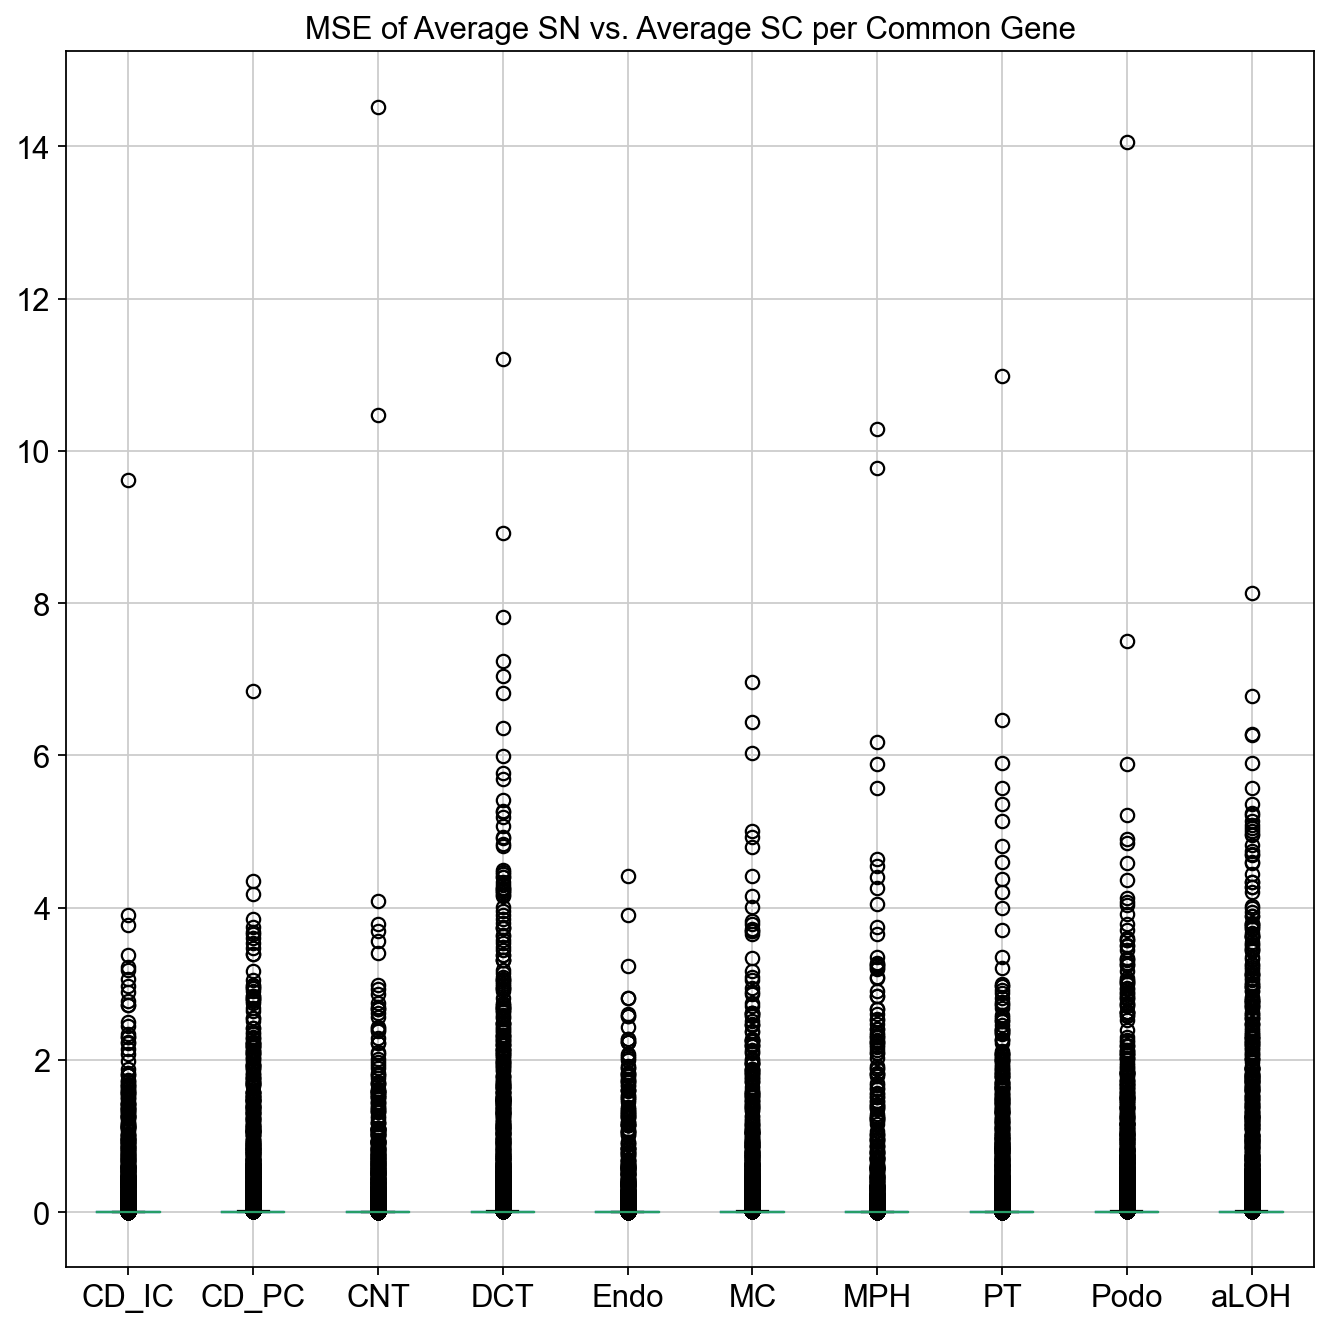

In [2021]:
plt.figure(figsize= [10,10])
mse_df.boxplot(column = ['CD_IC', 'CD_PC', 'CNT', 'DCT', 'Endo', 'MC', 'MPH', 'PT', 'Podo', 'aLOH'])
plt.title('MSE of Average SN vs. Average SC per Common Gene')

In [1950]:
#Code based from https://github.com/scverse/anndata/issues/73 falexwolf commented on Oct 20, 2018
#trimming down the bulk data to contain only genes available in common_genes SN and SC
common_gene_indicator_bulk = np.in1d(bulk_adata.var_names, common_genes_wbulk)
bulk_adata = bulk_adata[:, common_gene_indicator_bulk]
bulk_adata

View of AnnData object with n_obs × n_vars = 1 × 13686
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'log1p'

In [1951]:
bulk_adata_df = pd.DataFrame(bulk_adata.X, columns=bulk_adata.var_names)
#reordering columsn so they match    
bulk_adata_df= bulk_adata_df.reindex(sorted(bulk_adata_df.columns), axis=1)
bulk_adata_df

,0610007P14Rik,0610009B22Rik,0610009L18Rik,0610009O20Rik,0610010F05Rik,0610010K14Rik,0610011F06Rik,0610012G03Rik,0610025J13Rik,0610030E20Rik,...,Zufsp,Zw10,Zwint,Zxdb,Zxdc,Zyg11b,Zyx,Zzef1,Zzz3,l7Rn6
0,6.539586,6.411819,4.094345,7.467371,6.084499,3.850147,8.11552,7.056175,2.833213,7.049255,...,5.47227,6.375025,7.500529,5.036952,6.526495,7.653495,7.010312,7.54009,7.254885,6.251904


In [1952]:
#trimming down the sn and sc data  to contain only genes available in bulk as well.
sn_adata = sn_adata[:, common_genes_wbulk]
sc_adata = sc_adata[:, common_genes_wbulk]

In [1953]:
av_per_gene_sn = pd.DataFrame(columns=sn_adata.var_names, index = [1])
av_per_gene_sc = pd.DataFrame(columns=sn_adata.var_names, index = [1])

In [1954]:
for gene in sn_adata.var_names:
    sum_per_gene = 0 
    for cell in matching_celltypes: 
        sum_per_gene = sum_per_gene + res_inner.loc[f"single_nucleus_{cell}"][gene] 
    av_per_gene_sn[gene] = sum_per_gene / len(matching_celltypes)
av_per_gene_sn    

,0610007P14Rik,0610009B22Rik,0610009L18Rik,0610009O20Rik,0610010F05Rik,0610010K14Rik,0610011F06Rik,0610012G03Rik,0610025J13Rik,0610030E20Rik,...,Zufsp,Zw10,Zwint,Zxdb,Zxdc,Zyg11b,Zyx,Zzef1,Zzz3,l7Rn6
1,0.019967,0.017308,0.00813,0.024251,0.016545,0.0,0.0,0.039726,0.000902,0.035526,...,0.016692,0.010723,0.032587,0.0052,0.013463,0.03294,0.013916,0.089453,0.054176,0.015984


In [1955]:
for gene in sc_adata.var_names:
    sum_per_gene = 0 
    for cell in matching_celltypes: 
        sum_per_gene = sum_per_gene + res_inner.loc[f"single_cell_{cell}"][gene] 
    av_per_gene_sc[gene] = sum_per_gene / len(matching_celltypes)
av_per_gene_sc   

,0610007P14Rik,0610009B22Rik,0610009L18Rik,0610009O20Rik,0610010F05Rik,0610010K14Rik,0610011F06Rik,0610012G03Rik,0610025J13Rik,0610030E20Rik,...,Zufsp,Zw10,Zwint,Zxdb,Zxdc,Zyg11b,Zyx,Zzef1,Zzz3,l7Rn6
1,0.088717,0.175096,0.053436,0.059838,0.02351,0.05047,0.315984,0.424381,0.003925,0.080191,...,0.022786,0.01413,0.08856,0.017342,0.026513,0.062907,0.050906,0.065947,0.055932,0.113467


In [1956]:
mse_df_snbulk = pd.DataFrame(columns=sn_adata.var_names, index = [1])
mse_df_scbulk = pd.DataFrame(columns=sn_adata.var_names, index = [1])

In [1973]:
#Getting a dataframe with all the mean square errors of each cell type and gene pair average expression.
for gene in bulk_adata_df.columns:
    val = mean_sqr_error(av_per_gene_sc[gene].values[0], bulk_adata_df[gene].values[0])
    mse_df_scbulk[gene] = val
mse_df_scbulk

,0610007P14Rik,0610009B22Rik,0610009L18Rik,0610009O20Rik,0610010F05Rik,0610010K14Rik,0610011F06Rik,0610012G03Rik,0610025J13Rik,0610030E20Rik,...,Zufsp,Zw10,Zwint,Zxdb,Zxdc,Zyg11b,Zyx,Zzef1,Zzz3,l7Rn6
1,41.613708,38.896705,16.328942,54.871546,36.735595,14.437553,60.832767,43.980701,8.004872,48.567857,...,29.696879,40.460986,54.93729,25.196494,42.249772,57.617019,48.433333,55.862816,51.824923,37.680412


In [1974]:
#Getting a dataframe with all the mean square errors of each cell type and gene pair average expression.
for gene in bulk_adata_df.columns:
    mse_df_snbulk[gene] = mean_sqr_error(av_per_gene_sn[gene].values[0], bulk_adata_df[gene].values[0])
mse_df_snbulk

,0610007P14Rik,0610009B22Rik,0610009L18Rik,0610009O20Rik,0610010F05Rik,0610010K14Rik,0610011F06Rik,0610012G03Rik,0610025J13Rik,0610030E20Rik,...,Zufsp,Zw10,Zwint,Zxdb,Zxdc,Zyg11b,Zyx,Zzef1,Zzz3,l7Rn6
1,42.50543,40.889769,16.697152,55.400028,36.820065,14.823636,65.861673,49.230563,8.021988,49.192395,...,29.763334,40.504339,55.770164,25.318529,42.41959,58.072862,48.949565,55.511994,51.850205,38.886693


In [1982]:
frames = [mse_df_snbulk, mse_df_scbulk]
mse_both = pd.concat(frames, keys=['single_nucleus', 'single_cell'])
mse_both

,,0610007P14Rik,0610009B22Rik,0610009L18Rik,0610009O20Rik,0610010F05Rik,0610010K14Rik,0610011F06Rik,0610012G03Rik,0610025J13Rik,0610030E20Rik,...,Zufsp,Zw10,Zwint,Zxdb,Zxdc,Zyg11b,Zyx,Zzef1,Zzz3,l7Rn6
single_nucleus,1,42.505430,40.889769,16.697152,55.400028,36.820065,14.823636,65.861673,49.230563,8.021988,49.192395,...,29.763334,40.504339,55.770164,25.318529,42.419590,58.072862,48.949565,55.511994,51.850205,38.886693
single_cell,1,41.613708,38.896705,16.328942,54.871546,36.735595,14.437553,60.832767,43.980701,8.004872,48.567857,...,29.696879,40.460986,54.937290,25.196494,42.249772,57.617019,48.433333,55.862816,51.824923,37.680412


In [1984]:
mse_both = mse_both.transpose()

Text(0.5, 1.0, 'MSE of Bulk Expr. vs. Average Expr. in SN and SC')

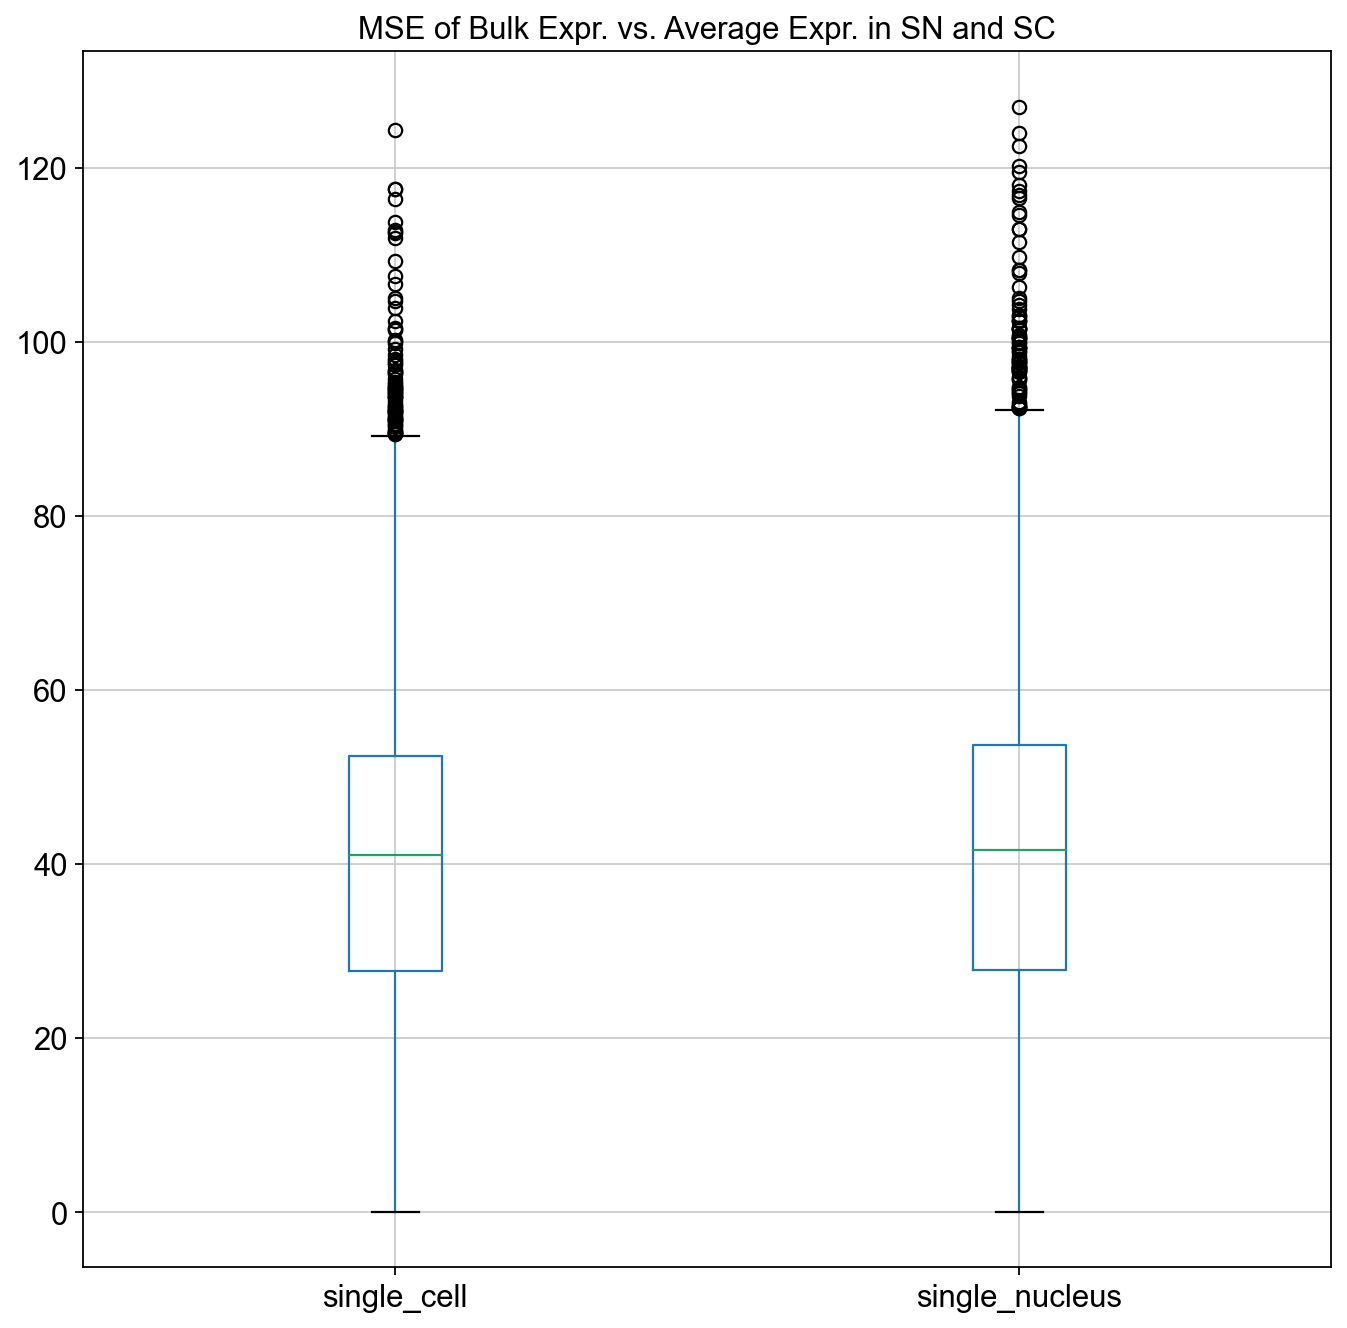

In [1998]:
plt.figure(figsize= [10,10])
mse_both.boxplot(column = ['single_cell', 'single_nucleus'])
plt.title('MSE of Bulk Expr. vs. Average Expr. in SN and SC')
#mean square error plot:

In [2022]:
#creating dataframes to append values to
pear_df = pd.DataFrame(columns=res_inner.columns, index = matching_celltypes)
pear_df_snbulk  = pd.DataFrame(columns=res_inner.columns)
pear_df_scbulk  = pd.DataFrame(columns=res_inner.columns)

In [2026]:
sc_adata.obs

,cell_type,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,leiden,louvain,orig,orig_and_celltype
LD01_SC_FRESH_AAACCCACAACCACAT,CD_IC,1334,2283.0,7.0,0.306614,32,16,single_cell,single_cell_CD_IC
LD01_SC_FRESH_AAACCCAGTATGACAA,CD_IC,512,780.0,1.0,0.128205,5,8,single_cell,single_cell_CD_IC
LD01_SC_FRESH_AAACCCAGTTCAAGGG,CNT,1819,5290.0,13.0,0.245747,10,5,single_cell,single_cell_CNT
LD01_SC_FRESH_AAACCCATCAGCTTCC,PT,729,1227.0,4.0,0.325998,2,1,single_cell,single_cell_PT
LD01_SC_FRESH_AAACCCATCCTTTGAT,CD_PC,780,1284.0,4.0,0.311526,20,20,single_cell,single_cell_CD_PC
...,...,...,...,...,...,...,...,...,...
LD01_SC_FRESH_TTTGTTGGTGAGATCG,PT,1405,3465.0,8.0,0.230880,9,9,single_cell,single_cell_PT
LD01_SC_FRESH_TTTGTTGGTTTCACAG,CNT,564,901.0,3.0,0.332963,5,8,single_cell,single_cell_CNT
LD01_SC_FRESH_TTTGTTGTCCCTCGTA,aLOH,668,933.0,4.0,0.428725,1,0,single_cell,single_cell_aLOH
LD01_SC_FRESH_TTTGTTGTCGAGAGAC,Endo,346,422.0,2.0,0.473934,22,13,single_cell,single_cell_Endo


In [2025]:
sc_adata.obs['cell_type'] ==  cell

View of AnnData object with n_obs × n_vars = 4606 × 13686
    obs: 'cell_type', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'louvain', 'orig', 'orig_and_celltype'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'louvain', 'leiden_colors', 'cell_type_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [2030]:
sc_adata.var_names

Index(['0610007P14Rik', '0610009B22Rik', '0610009L18Rik', '0610009O20Rik',
       '0610010F05Rik', '0610010K14Rik', '0610011F06Rik', '0610012G03Rik',
       '0610025J13Rik', '0610030E20Rik',
       ...
       'Zufsp', 'Zw10', 'Zwint', 'Zxdb', 'Zxdc', 'Zyg11b', 'Zyx', 'Zzef1',
       'Zzz3', 'l7Rn6'],
      dtype='object', length=13686)

In [2032]:
sc_adata.var

,mt,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,highly_variable,means,dispersions,dispersions_norm
0610007P14Rik,False,598,0.153930,87.016934,709.0,False,0.143173,0.209286,0.092138
0610009B22Rik,False,1065,0.293747,76.877985,1353.0,False,0.257543,0.197188,-0.592966
0610009L18Rik,False,284,0.066869,93.834129,308.0,False,0.064728,0.085454,-0.336749
0610009O20Rik,False,308,0.071211,93.313070,328.0,False,0.068790,0.055498,-0.440500
0610010F05Rik,False,166,0.038428,96.396005,177.0,False,0.037708,0.082595,-0.346651
...,...,...,...,...,...,...,...,...,...
Zyg11b,False,352,0.084021,92.357794,387.0,False,0.080677,0.111338,-0.247102
Zyx,False,281,0.070343,93.899262,324.0,False,0.067979,0.213956,0.108311
Zzef1,False,370,0.089014,91.967000,410.0,False,0.085273,0.118551,-0.222119
Zzz3,False,312,0.075337,93.226227,347.0,False,0.072634,0.144500,-0.132245


In [2045]:
gene = '0610007P14Rik'
cell = 'MC'
vals  = sc_adata[sc_adata.obs['cell_type'] == cell]
vals = vals[vals.var_keys==gene]
vals.X

ArrayView([[0.       , 0.       , 0.       , ..., 0.       , 0.       ,
            0.6931472]], dtype=float32)

In [2054]:
#Getting a dataframe with all the mean square errors of each cell type and gene pair average expression.
for gene in sc_adata.var_names:
    for cell in matching_celltypes:
        vals_sc  = sc_adata[sc_adata.obs['cell_type'] == cell]
        vals_sc = vals_sc[vals_sc.var_keys==gene]
        sc_vals = vals_sc.X

        vals_sn  = sn_adata[sn_adata.obs['cell_type'] == cell]
        vals_sn = vals_sn[vals_sn.var_keys==gene]
        sn_vals = vals_sn.X

        pear_df.loc[cell][gene] = [pearsonr(sc_vals[0], sn_vals[0])[0]]
pear_df

,0610007P14Rik,0610009B22Rik,0610009L18Rik,0610009O20Rik,0610010F05Rik,0610010K14Rik,0610011F06Rik,0610012G03Rik,0610025J13Rik,0610030E20Rik,...,Zufsp,Zw10,Zwint,Zxdb,Zxdc,Zyg11b,Zyx,Zzef1,Zzz3,l7Rn6
CD_IC,[0.06965127031460393],[0.06965127031460393],[0.06965127031460393],[0.06965127031460393],[0.06965127031460393],[0.06965127031460393],[0.06965127031460393],[0.06965127031460393],[0.06965127031460393],[0.06965127031460393],...,[0.06965127031460393],[0.06965127031460393],[0.06965127031460393],[0.06965127031460393],[0.06965127031460393],[0.06965127031460393],[0.06965127031460393],[0.06965127031460393],[0.06965127031460393],[0.06965127031460393]
CD_PC,[0.10499599461914741],[0.10499599461914741],[0.10499599461914741],[0.10499599461914741],[0.10499599461914741],[0.10499599461914741],[0.10499599461914741],[0.10499599461914741],[0.10499599461914741],[0.10499599461914741],...,[0.10499599461914741],[0.10499599461914741],[0.10499599461914741],[0.10499599461914741],[0.10499599461914741],[0.10499599461914741],[0.10499599461914741],[0.10499599461914741],[0.10499599461914741],[0.10499599461914741]
CNT,[0.05646261021645261],[0.05646261021645261],[0.05646261021645261],[0.05646261021645261],[0.05646261021645261],[0.05646261021645261],[0.05646261021645261],[0.05646261021645261],[0.05646261021645261],[0.05646261021645261],...,[0.05646261021645261],[0.05646261021645261],[0.05646261021645261],[0.05646261021645261],[0.05646261021645261],[0.05646261021645261],[0.05646261021645261],[0.05646261021645261],[0.05646261021645261],[0.05646261021645261]
DCT,[0.12353995273534131],[0.12353995273534131],[0.12353995273534131],[0.12353995273534131],[0.12353995273534131],[0.12353995273534131],[0.12353995273534131],[0.12353995273534131],[0.12353995273534131],[0.12353995273534131],...,[0.12353995273534131],[0.12353995273534131],[0.12353995273534131],[0.12353995273534131],[0.12353995273534131],[0.12353995273534131],[0.12353995273534131],[0.12353995273534131],[0.12353995273534131],[0.12353995273534131]
Endo,[0.0833449525878423],[0.0833449525878423],[0.0833449525878423],[0.0833449525878423],[0.0833449525878423],[0.0833449525878423],[0.0833449525878423],[0.0833449525878423],[0.0833449525878423],[0.0833449525878423],...,[0.0833449525878423],[0.0833449525878423],[0.0833449525878423],[0.0833449525878423],[0.0833449525878423],[0.0833449525878423],[0.0833449525878423],[0.0833449525878423],[0.0833449525878423],[0.0833449525878423]
MC,[0.11029338117865654],[0.11029338117865654],[0.11029338117865654],[0.11029338117865654],[0.11029338117865654],[0.11029338117865654],[0.11029338117865654],[0.11029338117865654],[0.11029338117865654],[0.11029338117865654],...,[0.11029338117865654],[0.11029338117865654],[0.11029338117865654],[0.11029338117865654],[0.11029338117865654],[0.11029338117865654],[0.11029338117865654],[0.11029338117865654],[0.11029338117865654],[0.11029338117865654]
MPH,[0.13353285344386973],[0.13353285344386973],[0.13353285344386973],[0.13353285344386973],[0.13353285344386973],[0.13353285344386973],[0.13353285344386973],[0.13353285344386973],[0.13353285344386973],[0.13353285344386973],...,[0.13353285344386973],[0.13353285344386973],[0.13353285344386973],[0.13353285344386973],[0.13353285344386973],[0.13353285344386973],[0.13353285344386973],[0.13353285344386973],[0.13353285344386973],[0.13353285344386973]
PT,[0.13043215356722232],[0.13043215356722232],[0.13043215356722232],[0.13043215356722232],[0.13043215356722232],[0.13043215356722232],[0.13043215356722232],[0.13043215356722232],[0.13043215356722232],[0.13043215356722232],...,[0.13043215356722232],[0.13043215356722232],[0.13043215356722232],[0.13043215356722232],[0.13043215356722232],[0.13043215356722232],[0.13043215356722232],[0.13043215356722232],[0.13043215356722232],[0.13043215356722232]
Podo,[0.2378498421724206],[0.2378498421724206],[0.2378498421724206],[0.2378498421724206],[0.2378498421724206],[0.2378498421724206],[0.2378498421724206],[0.2378498421724206],[0.2378498421724206],[0.2378498421724206],...,[0.23784984217

In [2076]:
#Getting a dataframe with all the mean square errors of each cell type and gene pair average expression.
for gene in sc_adata.var_names:
    for cell in matching_celltypes:
        vals_sc  = sc_adata[sc_adata.obs['cell_type'] == cell]
        vals_sc = vals_sc[vals_sc.var_keys==gene]
        sc_vals = vals_sc.X

        vals_sn  = sn_adata[sn_adata.obs['cell_type'] == cell]
        vals_sn = vals_sn[vals_sn.var_keys==gene]
        sn_vals = vals_sn.X

        pear_df.loc[cell][gene] = pearsonr(sc_vals[0], sn_vals[0])[0]
pear_df

KeyboardInterrupt: 

In [ ]:
pear_df = pear_df.astype('float')
pear_df = pear_df.transpose()
plt.figure(figsize= [10,10])
pear_df.boxplot(column = ['CD_IC', 'CD_PC', 'CNT', 'DCT', 'Endo', 'MC', 'MPH', 'PT', 'Podo', 'aLOH'])
plt.title('Pear of SN vs. SC per Common Gene')

ValueError: setting an array element with a sequence.

In [1963]:
pd.DataFrame(single_adata_inner.uns['rank_genes_groups']['names'])

KeyError: 'rank_genes_groups'